In [1]:
!pip install -U statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime,timedelta
from scipy import spatial
from scipy.cluster.hierarchy import linkage,dendrogram
from sklearn.cluster import DBSCAN,KMeans
from numpy.linalg import norm
from random import sample
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [5]:
archive = zipfile.ZipFile(r'/content/drive/MyDrive/compressed_dataset.csv.zip', 'r')
data = archive.open('compressed_dataset.csv')

df = pd.read_csv(data)
df.head()

,Unnamed: 0,timestamp,customer_id,event_id,viewer_id,city_id,country_id,viewer_type,qoe,engagement,buffer_ms
0,0,1632762065906,5.0,107.0,11661.0,2.0,3.0,WFO,0.999976,0.0,785
1,19,1632762104254,5.0,107.0,12810.0,2.0,3.0,WFH,0.281964,0.9,3895
2,40,1632762108299,5.0,107.0,15129.0,19.0,3.0,WFH,1.000000,0.9,0
3,55,1632762112510,5.0,107.0,5860.0,217.0,3.0,WFH,0.999988,0.0,466
4,78,1632762129231,5.0,107.0,4483.0,2.0,3.0,WFO,1.000000,0.0,0


In [6]:
df['date_time'] = pd.to_datetime(df['timestamp'], unit='ms')
df.head()

,Unnamed: 0,timestamp,customer_id,event_id,viewer_id,city_id,country_id,viewer_type,qoe,engagement,buffer_ms,date_time
0,0,1632762065906,5.0,107.0,11661.0,2.0,3.0,WFO,0.999976,0.0,785,2021-09-27 17:01:05.906
1,19,1632762104254,5.0,107.0,12810.0,2.0,3.0,WFH,0.281964,0.9,3895,2021-09-27 17:01:44.254
2,40,1632762108299,5.0,107.0,15129.0,19.0,3.0,WFH,1.000000,0.9,0,2021-09-27 17:01:48.299
3,55,1632762112510,5.0,107.0,5860.0,217.0,3.0,WFH,0.999988,0.0,466,2021-09-27 17:01:52.510
4,78,1632762129231,5.0,107.0,4483.0,2.0,3.0,WFO,1.000000,0.0,0,2021-09-27 17:02:09.231


In [ ]:
print("Data available from",df['date_time'].min(),"to",df['date_time'].max())

Data available from 2021-09-27 17:00:46.726000 to 2022-03-21 14:24:10.480000


In [ ]:
print("customer_id values:",int(df.customer_id.min()),"-",int(df.customer_id.max()))
print("event_id values:",int(df.event_id.min()),"-",int(df.event_id.max()))
print("viewer_id values:",int(df.viewer_id.min()),"-",int(df.viewer_id.max()))
print("city_id values:",int(df.city_id.min()),"-",int(df.city_id.max()))
print("country_id values:",int(df.country_id.min()),"-",int(df.country_id.max()))

customer_id values: 0 - 32
event_id values: 0 - 733
viewer_id values: 0 - 108973
city_id values: 0 - 8242
country_id values: 0 - 123


# Viewers’ engagement distribution over time

## customer_id

In [ ]:
customer_list = []

for CustomerId in tqdm(range(33),desc="Calculating viewers' engagement distribution..."):
  customer_df = df[df['customer_id'] == CustomerId]
  temp_df = customer_df[['date_time','engagement']]
  temp_df = temp_df.assign(date_time=temp_df.date_time.dt.round('H'))
  temp = temp_df.groupby('date_time').agg([np.mean,np.std])
  customer_list.append(temp)

Calculating viewers' engagement distribution...: 100%|██████████| 33/33 [00:04<00:00,  6.76it/s]


In [ ]:
cos_distance_array = np.zeros((33,33))
x = -1
y = -1

for customer1 in tqdm(customer_list,desc='Calculating the cos distance array...'):
  customer1_data = customer1.iloc[:,0].to_numpy()
  x += 1
  y = -1
  for customer2 in customer_list:
    y += 1
    customer2_data = customer2.iloc[:,0].to_numpy()
    if(x <= y):
      continue
    if len(customer1_data) >= len(customer2_data):
      inp1 = customer1_data
      inp2 = np.pad(customer2_data,(0,len(customer1_data) - len(customer2_data)),'constant')
    else:
      inp1 = np.pad(customer1_data,(0,len(customer2_data) - len(customer1_data)),'constant')
      inp2 = customer2_data
    cos_distance_array[x,y] = spatial.distance.cosine(inp1, inp2)
    cos_distance_array[y,x] = cos_distance_array[x,y]
    
  
  

Calculating the cos distance array...: 100%|██████████| 33/33 [00:00<00:00, 168.49it/s]


In [ ]:
cos_distance_array

array([[0.        , 0.35140255, 0.3906633 , ..., 0.2705149 , 0.18551307,
        0.55040343],
       [0.35140255, 0.        , 0.19153823, ..., 0.34649981, 0.3689491 ,
        0.69319579],
       [0.3906633 , 0.19153823, 0.        , ..., 0.32539982, 0.37612423,
        0.75368475],
       ...,
       [0.2705149 , 0.34649981, 0.32539982, ..., 0.        , 0.32580114,
        0.63175832],
       [0.18551307, 0.3689491 , 0.37612423, ..., 0.32580114, 0.        ,
        0.64094697],
       [0.55040343, 0.69319579, 0.75368475, ..., 0.63175832, 0.64094697,
        0.        ]])

In [ ]:
cluster_num = 3
kmeans = KMeans(n_clusters=cluster_num).fit(cos_distance_array)

In [ ]:
kmeans.labels_

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 2], dtype=int32)

Number of clusters: 3


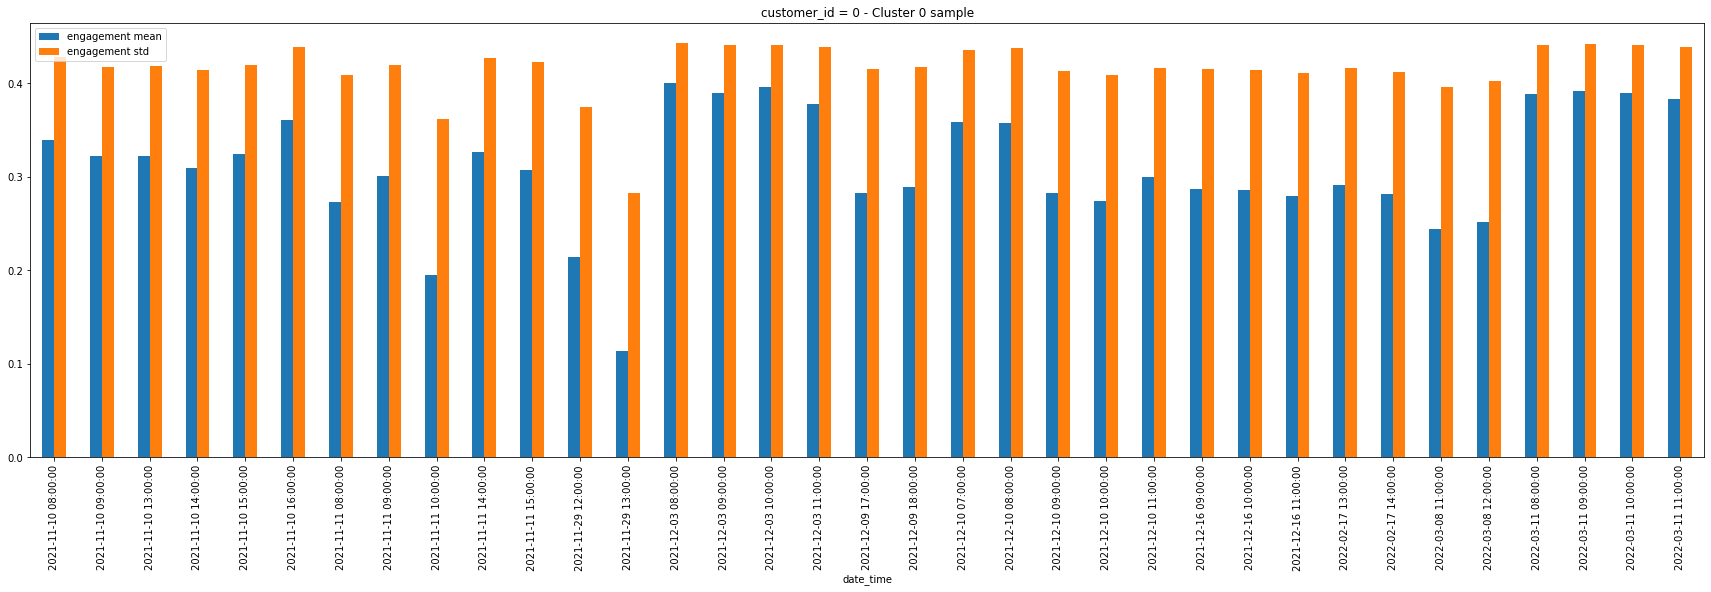

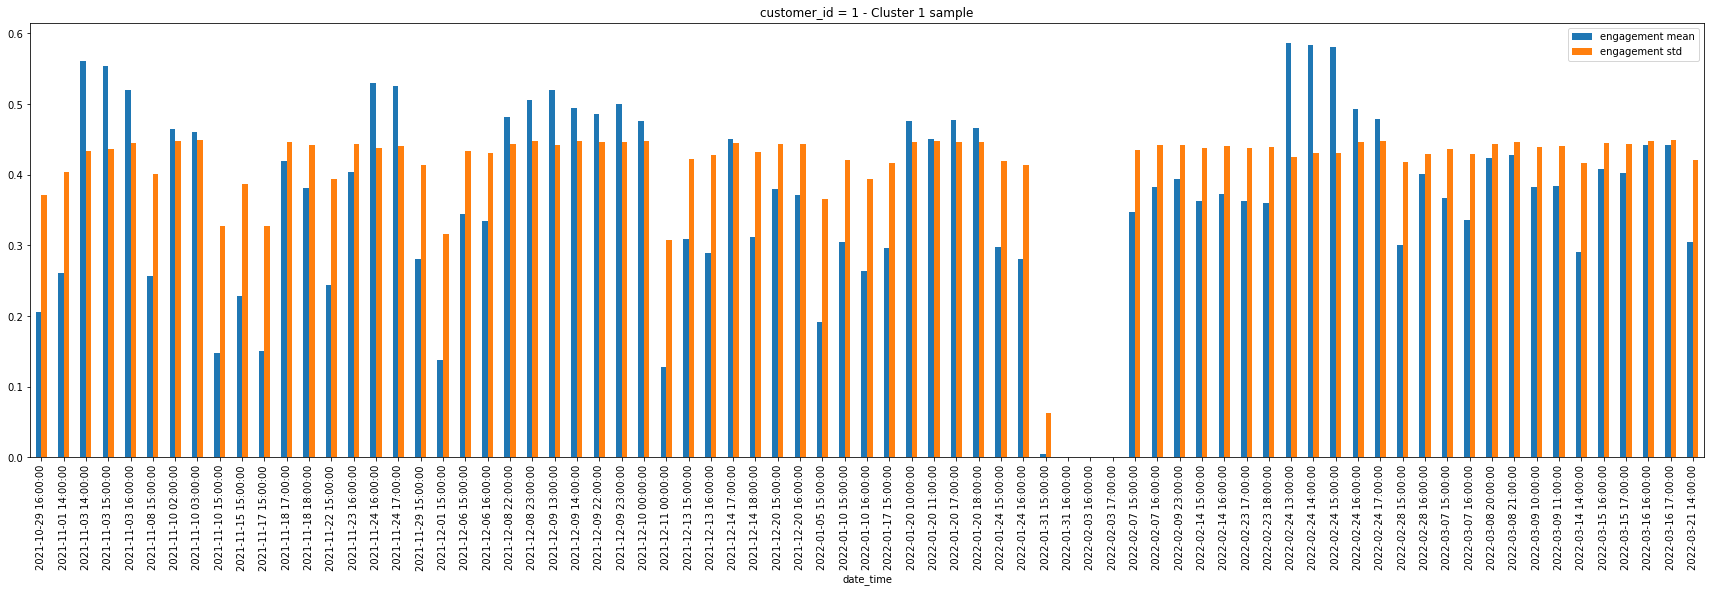

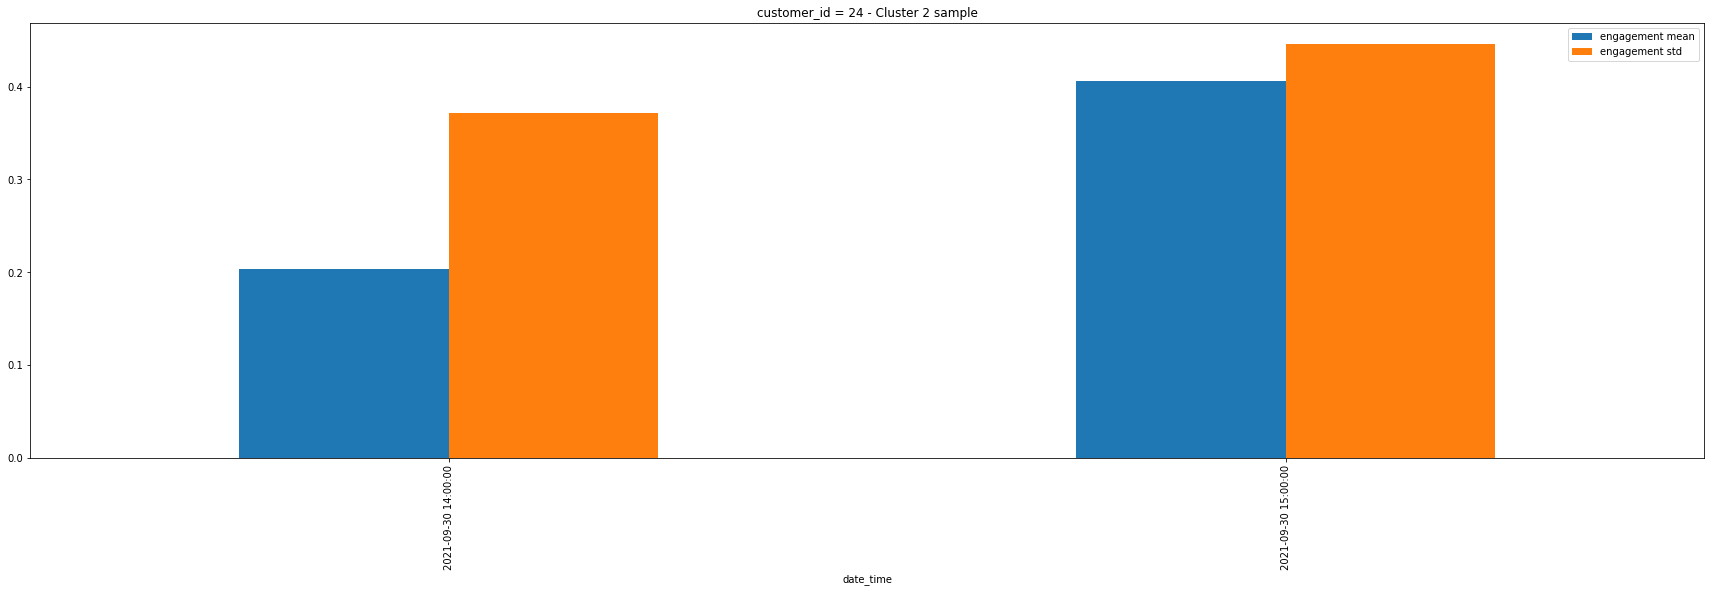

In [ ]:
print("Number of clusters:",cluster_num)
for i in range(cluster_num):
  CustomerId = np.where(kmeans.labels_==i)[0][0]
  cur = customer_list[CustomerId]
  fig, ax = plt.subplots()
  cur.plot(kind='bar',figsize=(30,8),title='customer_id = {:d} - Cluster {:d} sample'.format(CustomerId,i),ax=ax)
  ax.legend(["engagement mean", "engagement std"])

## country_id

In [ ]:
country_list = []

for CountryId in tqdm(range(124),desc="Calculating viewers' engagement distribution..."):
  country_df = df[df['country_id'] == CountryId]
  temp_df = country_df[['date_time','engagement']]
  temp_df = temp_df.assign(date_time=temp_df.date_time.dt.round('H'))
  temp = temp_df.groupby('date_time').agg([np.mean,np.std])
  country_list.append(temp)

Calculating viewers' engagement distribution...: 100%|██████████| 124/124 [00:10<00:00, 11.30it/s]


In [ ]:
cos_distance_array = np.zeros((124,124))
x = -1
y = -1

for country1 in tqdm(country_list,desc='Calculating the cos distance array...'):
  country1_data = country1.iloc[:,0].to_numpy()
  x += 1
  y = -1
  for country2 in country_list:
    y += 1
    country2_data = country2.iloc[:,0].to_numpy()
    if(x <= y):
      continue
    if len(country1_data) >= len(country2_data):
      inp1 = country1_data
      inp2 = np.pad(country2_data,(0,len(country1_data) - len(country2_data)),'constant')
    else:
      inp1 = np.pad(country1_data,(0,len(country2_data) - len(country1_data)),'constant')
      inp2 = country2_data
    if norm(inp1) == 0 or norm(inp2) == 0:
      cos_distance_array[x,y] = 1
      cos_distance_array[y,x] = 1
    else:
      cos_distance_array[x,y] = spatial.distance.cosine(inp1, inp2)
      cos_distance_array[y,x] = cos_distance_array[x,y]

Calculating the cos distance array...: 100%|██████████| 124/124 [00:02<00:00, 46.81it/s]


In [ ]:
cos_distance_array

array([[0.        , 0.40407029, 0.27460839, ..., 0.98758758, 0.98000131,
        1.        ],
       [0.40407029, 0.        , 0.39963993, ..., 0.93758786, 0.93221701,
        1.        ],
       [0.27460839, 0.39963993, 0.        , ..., 0.91522209, 0.9008478 ,
        1.        ],
       ...,
       [0.98758758, 0.93758786, 0.91522209, ..., 0.        , 0.13182424,
        1.        ],
       [0.98000131, 0.93221701, 0.9008478 , ..., 0.13182424, 0.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.        ]])

In [ ]:
cluster_num = 3
kmeans = KMeans(n_clusters=cluster_num).fit(cos_distance_array)

In [ ]:
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2,
       2, 1, 1, 0, 2, 1, 0, 0, 1, 2, 2, 2, 2, 0, 1, 2, 2, 2, 0, 0, 2, 2,
       2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0], dtype=int32)

Number of clusters: 3


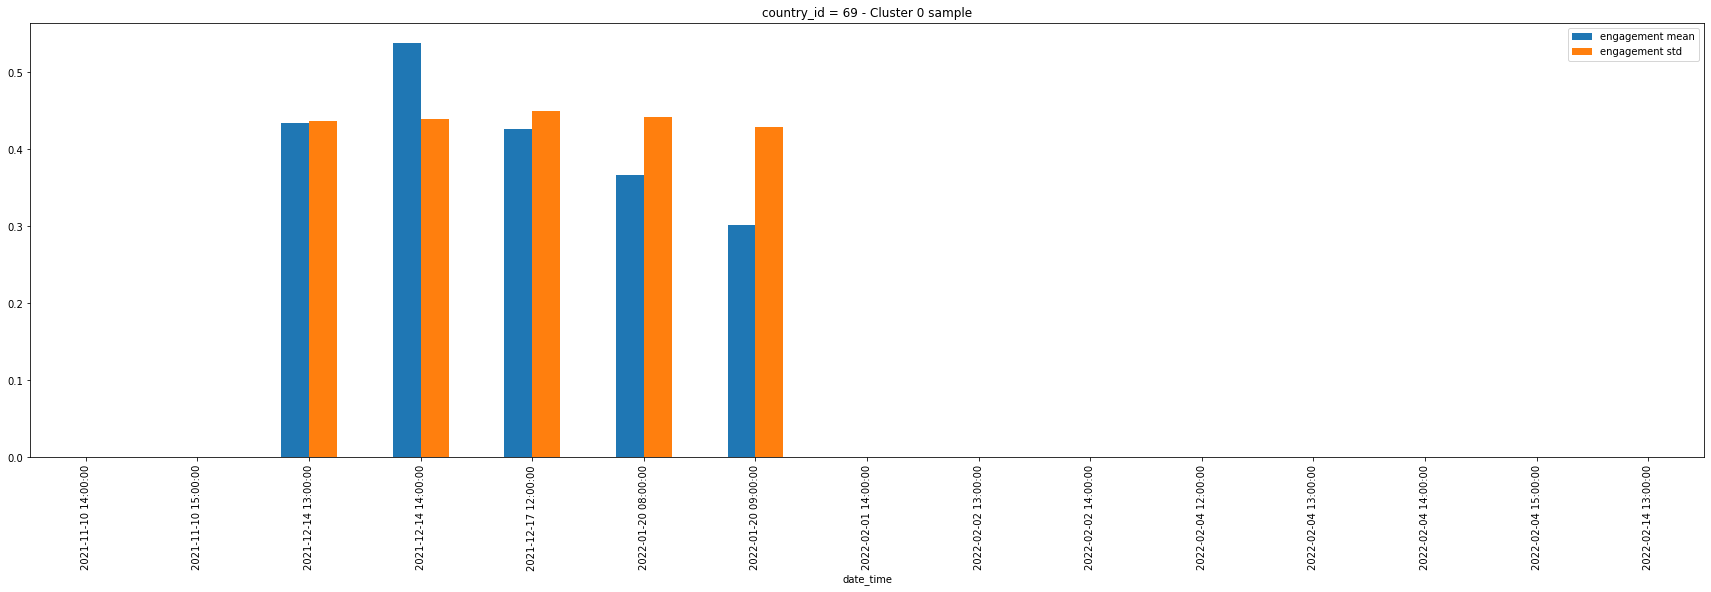

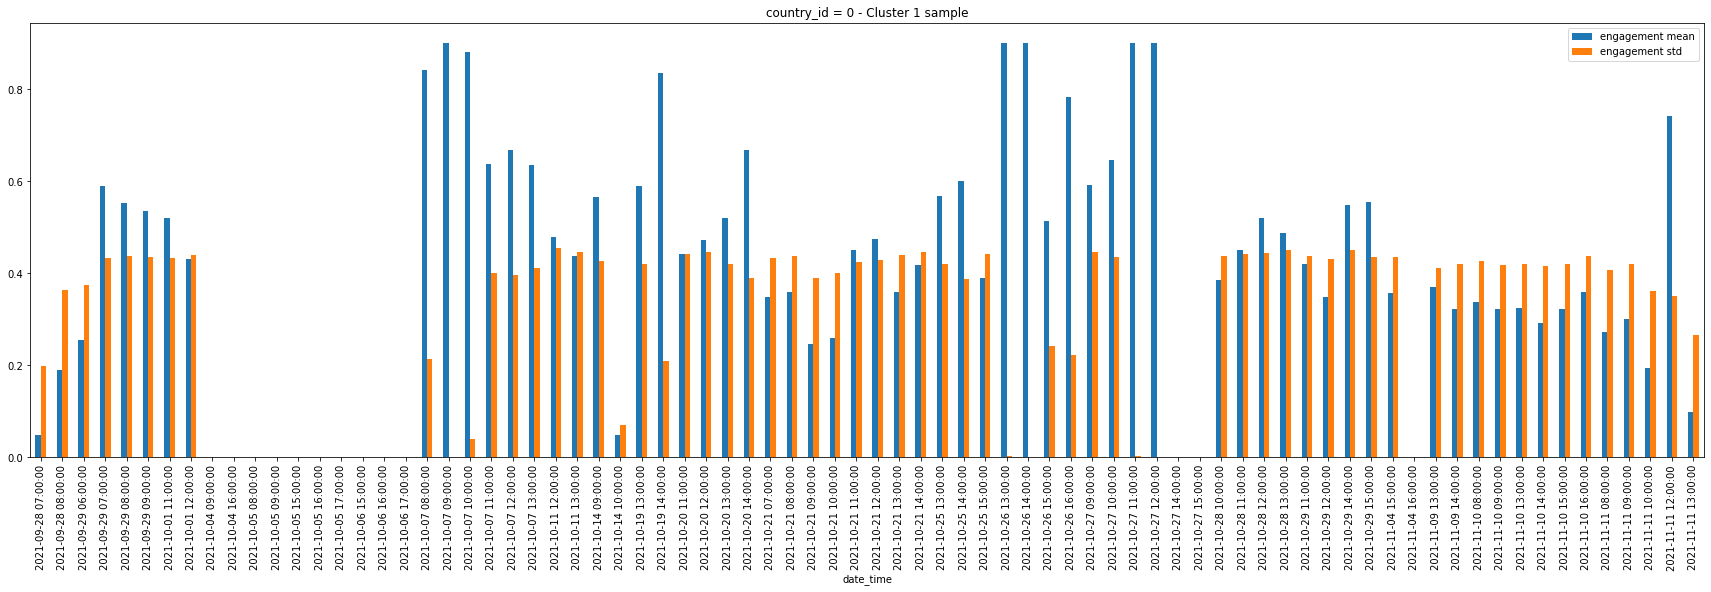

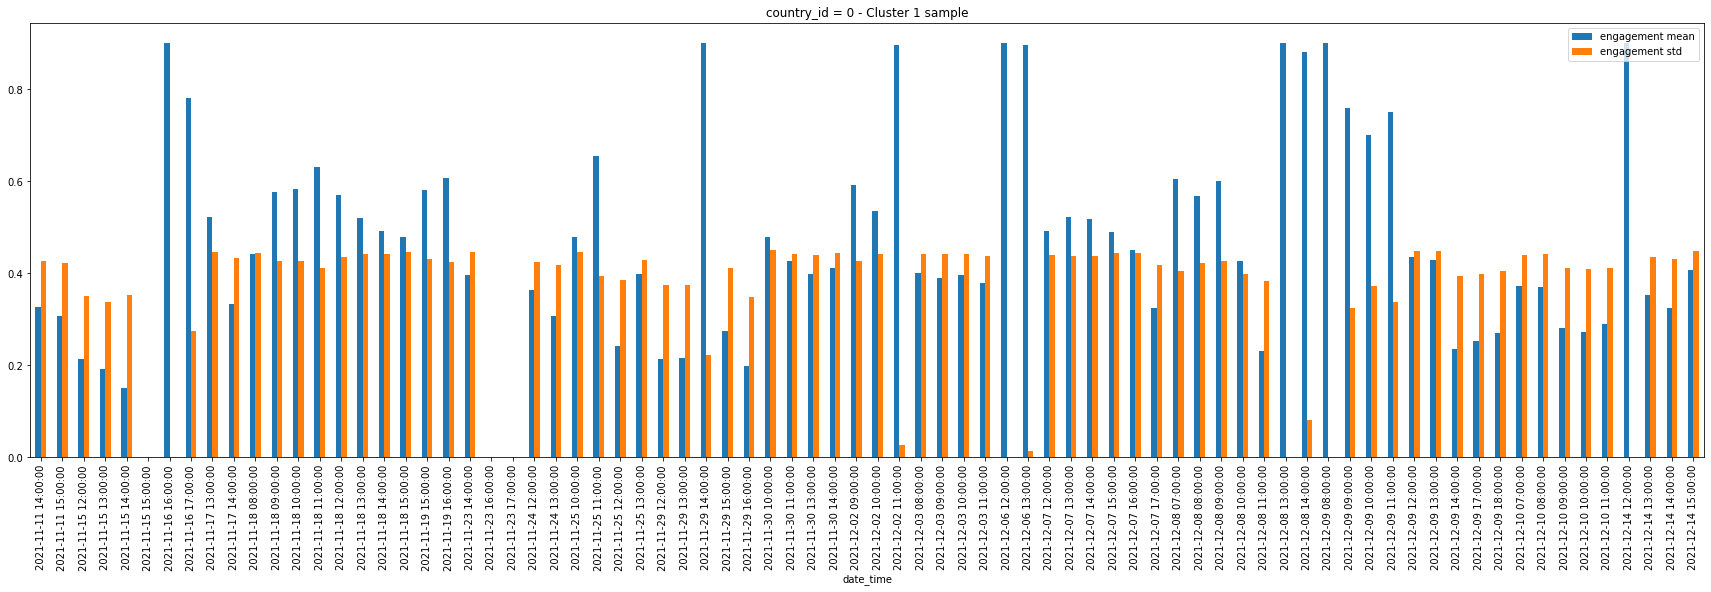

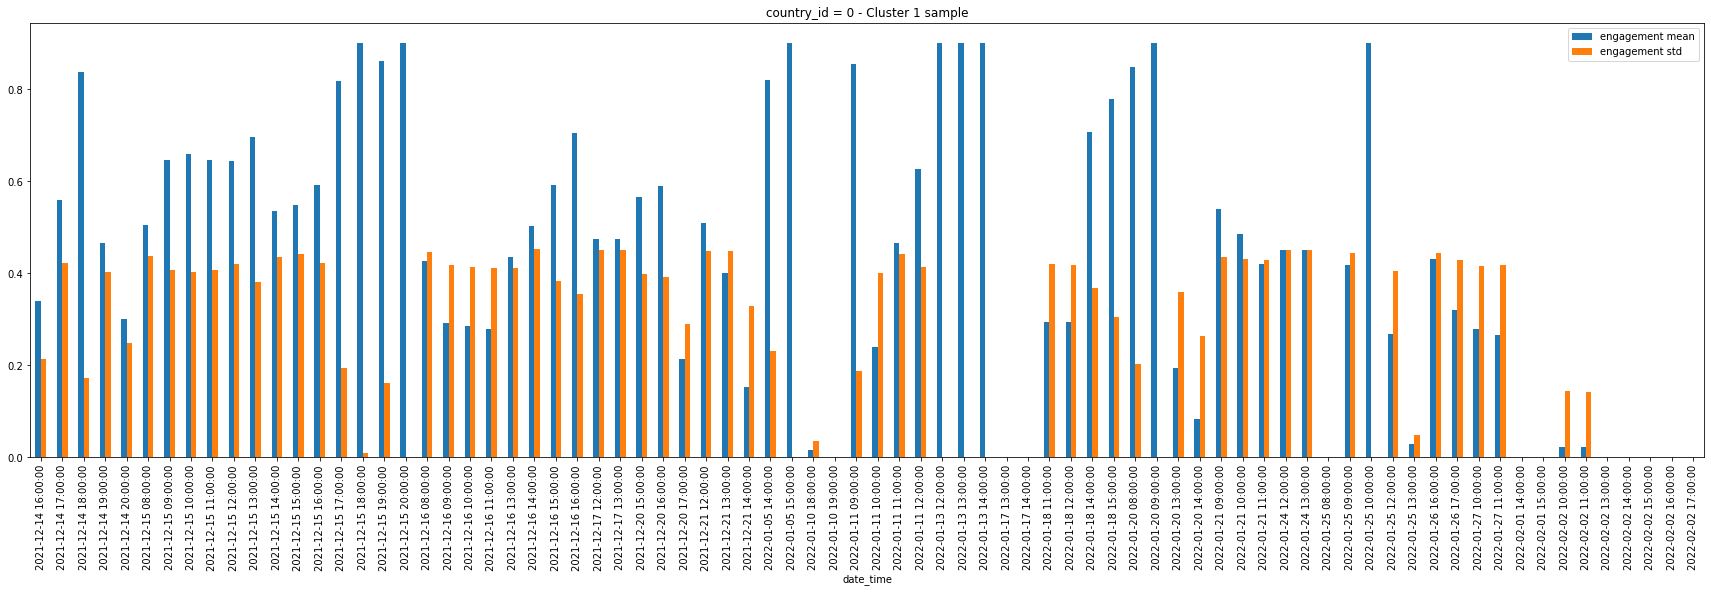

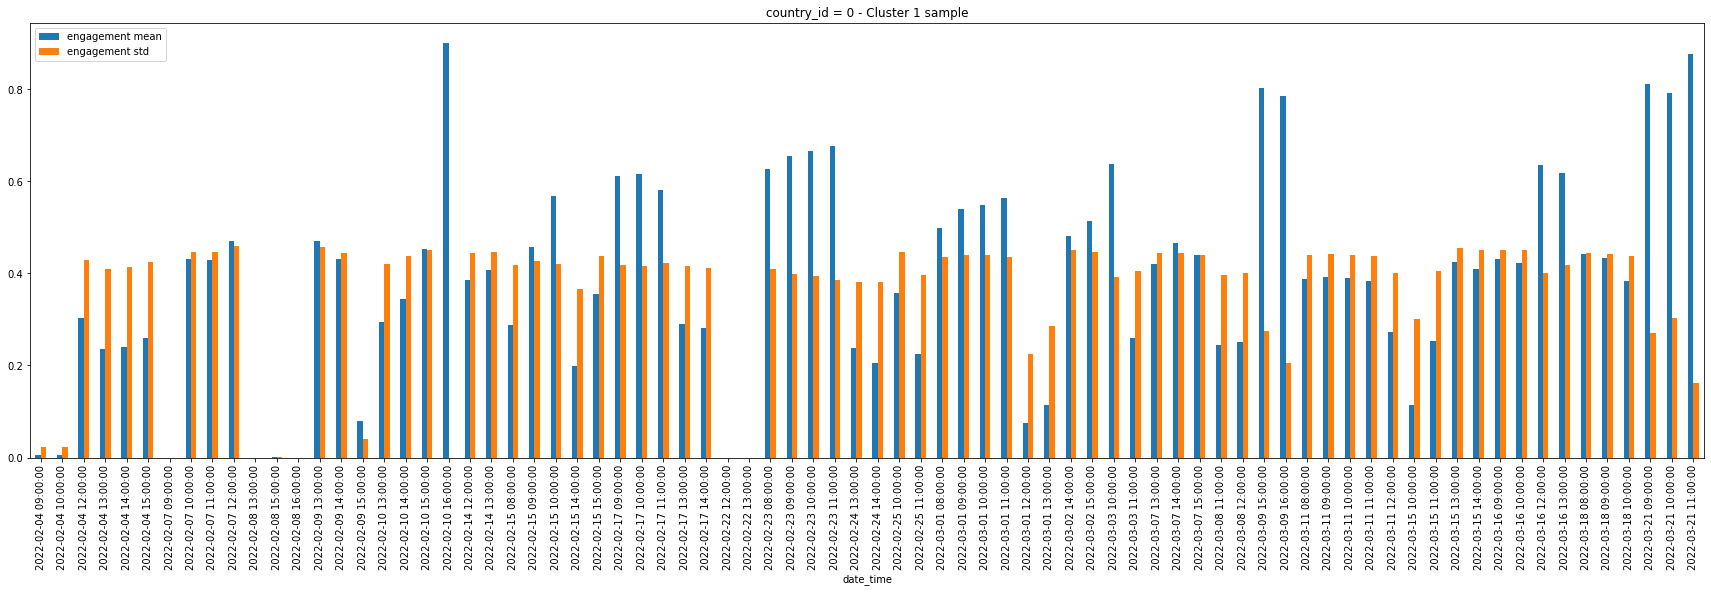

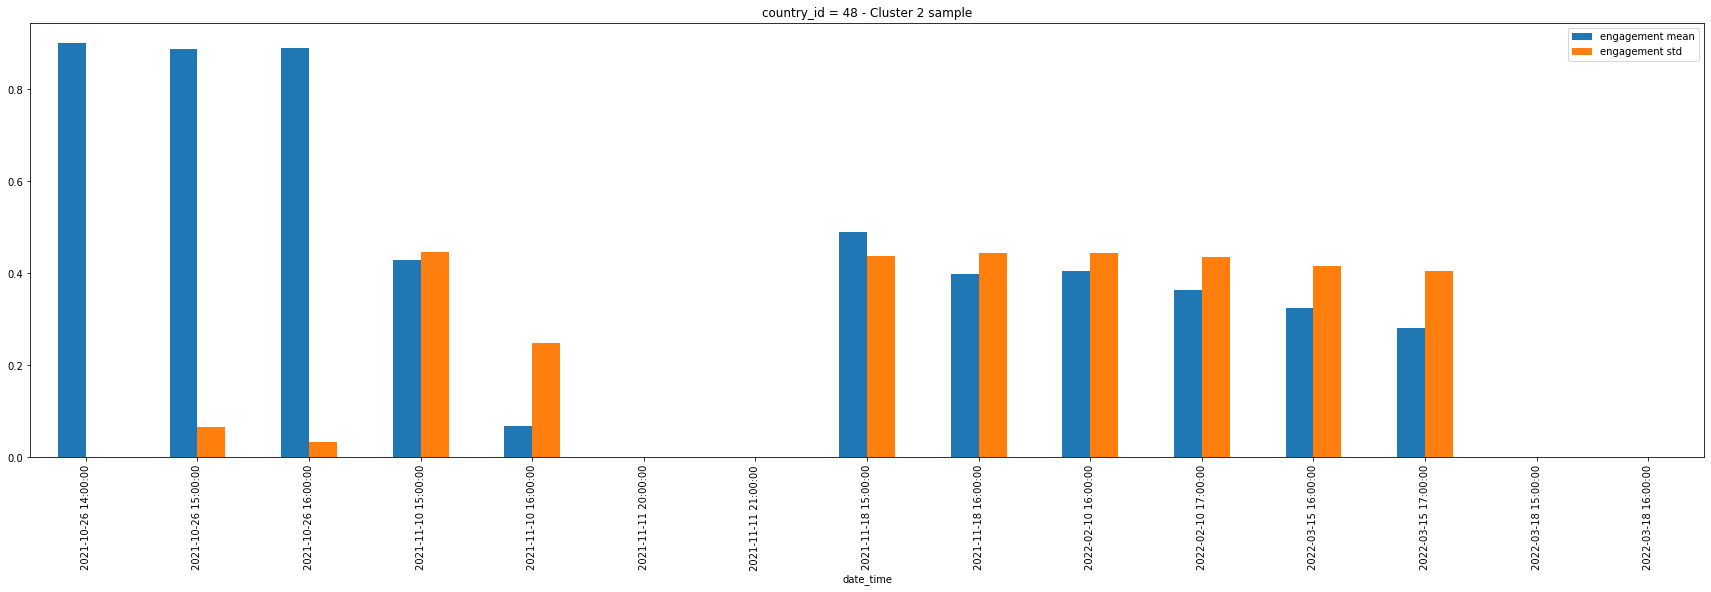

In [ ]:
print("Number of clusters:",cluster_num)
for i in range(cluster_num):
  CountryId = np.where(kmeans.labels_==i)[0][0]
  cur = country_list[CountryId]

  temp_list = np.array_split(cur, cur.shape[0]/80 + 1)
  for cur_list in temp_list:
    fig, ax = plt.subplots()
    cur_list.plot(kind='bar',figsize=(30,8),title='country_id = {:d} - Cluster {:d} sample'.format(CountryId,i),ax=ax)
    ax.legend(["engagement mean", "engagement std"])

## city_id

In [ ]:
city_list = []

for CityId in tqdm(range(8219),desc="Calculating viewers' engagement distribution..."):
  city_df = df[df['city_id'] == CityId]
  temp_df = city_df[['date_time','engagement']]
  temp_df = temp_df.assign(date_time=temp_df.date_time.dt.round('H'))
  temp = temp_df.groupby('date_time').agg([np.mean,np.std])
  city_list.append(temp)

Calculating viewers' engagement distribution...: 100%|██████████| 8219/8219 [07:40<00:00, 17.84it/s]


In [ ]:
cos_distance_array = np.zeros((8219,8219))
x = -1
y = -1

for city1 in tqdm(city_list,desc='Calculating the cos distance array...'):
  city1_data = city1.iloc[:,0].to_numpy()
  x += 1
  y = -1
  for city2 in city_list:
    y += 1
    if(x == y):
      break
    city2_data = city2.iloc[:,0].to_numpy()
    if len(city1_data) >= len(city2_data):
      inp1 = city1_data
      inp2 = np.pad(city2_data,(0,len(city1_data) - len(city2_data)),'constant')
    else:
      inp1 = np.pad(city1_data,(0,len(city2_data) - len(city1_data)),'constant')
      inp2 = city2_data
    if norm(inp1) == 0 or norm(inp2) == 0:
      cos_distance_array[x,y] = 1
      cos_distance_array[y,x] = 1
    else:
      cos_distance_array[x,y] = spatial.distance.cosine(inp1, inp2)
      cos_distance_array[y,x] = cos_distance_array[x,y]

Calculating the cos distance array...: 100%|██████████| 8219/8219 [2:09:12<00:00,  1.06it/s]


In [ ]:
cos_distance_array

array([[0.        , 0.57780196, 0.50941368, ..., 1.        , 1.        ,
        0.81539445],
       [0.57780196, 0.        , 0.44787816, ..., 1.        , 1.        ,
        0.95088659],
       [0.50941368, 0.44787816, 0.        , ..., 1.        , 1.        ,
        0.91150695],
       ...,
       [1.        , 1.        , 1.        , ..., 0.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 0.        ,
        1.        ],
       [0.81539445, 0.95088659, 0.91150695, ..., 1.        , 1.        ,
        0.        ]])

In [ ]:
cluster_num = 4
kmeans = KMeans(n_clusters=cluster_num).fit(cos_distance_array)

In [ ]:
kmeans.labels_

array([3, 1, 3, ..., 1, 1, 2], dtype=int32)

Number of clusters: 4


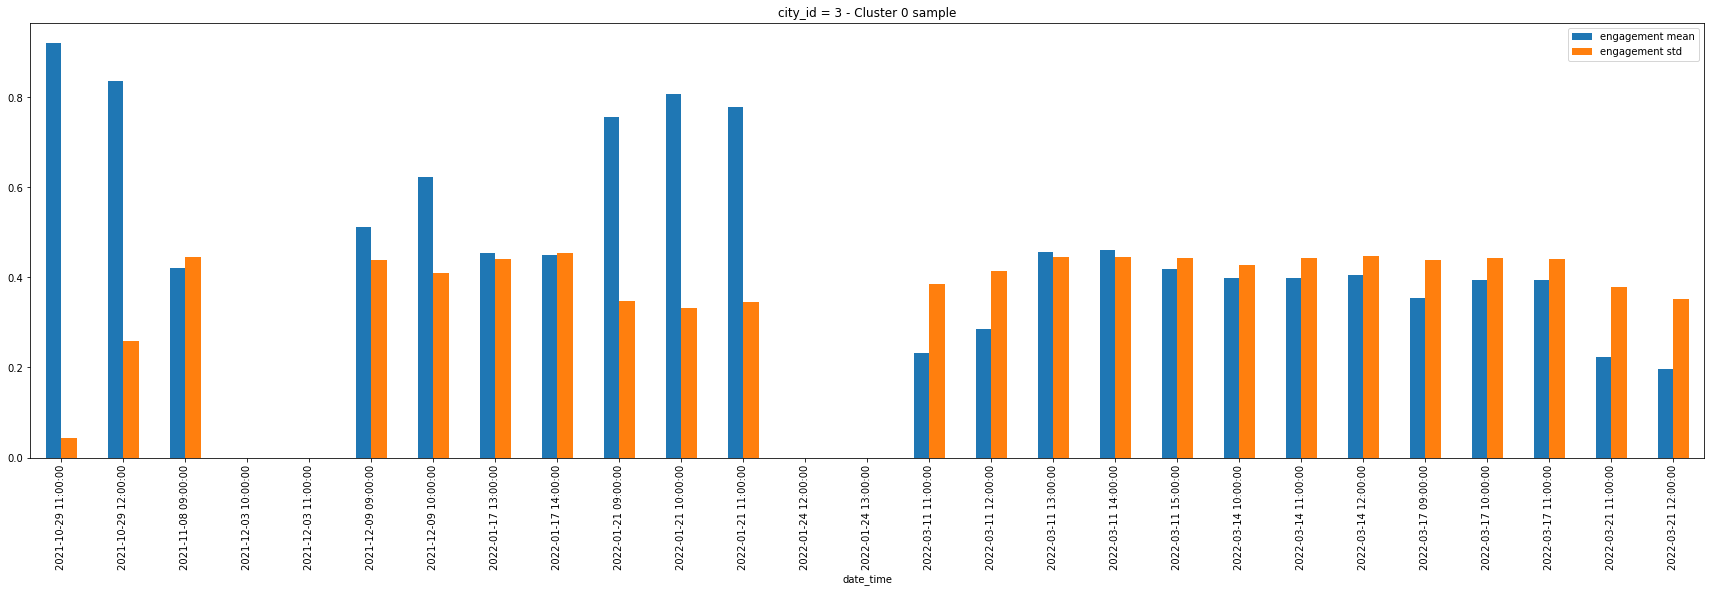

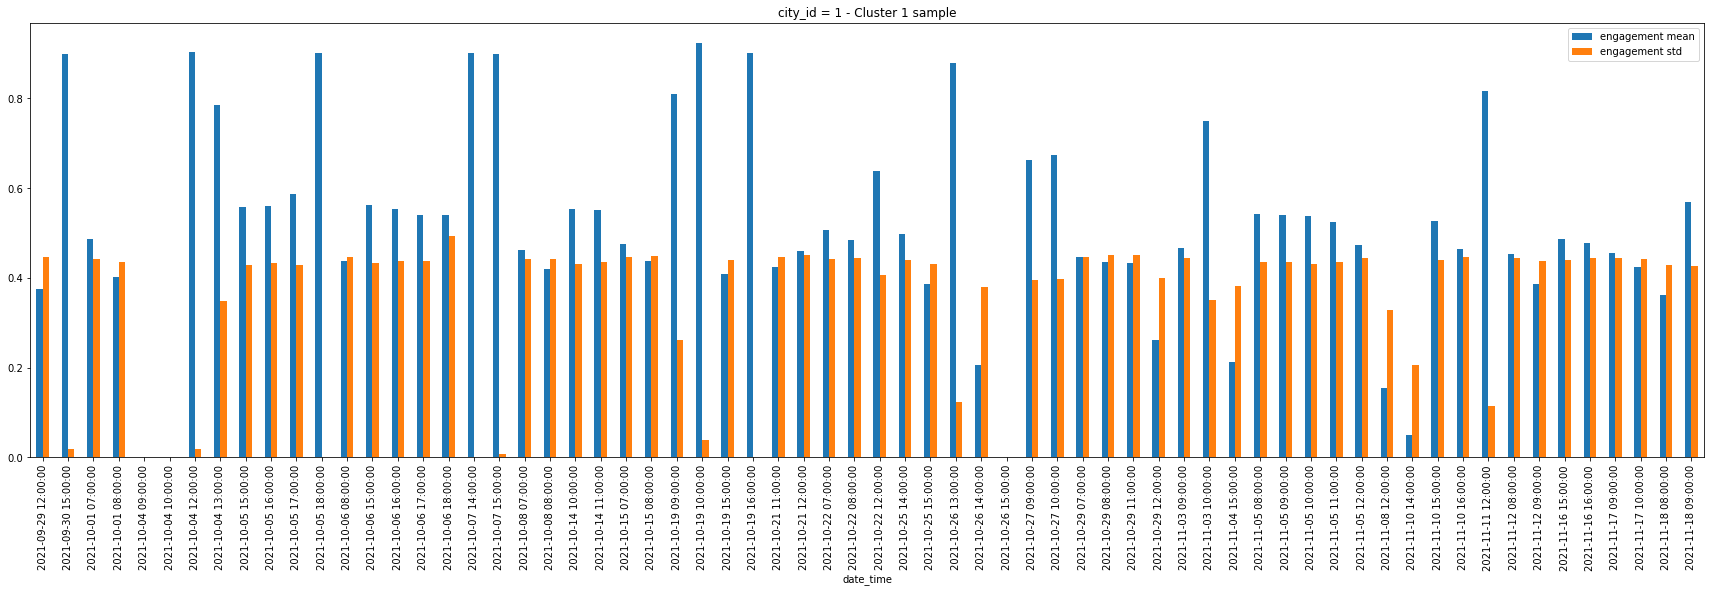

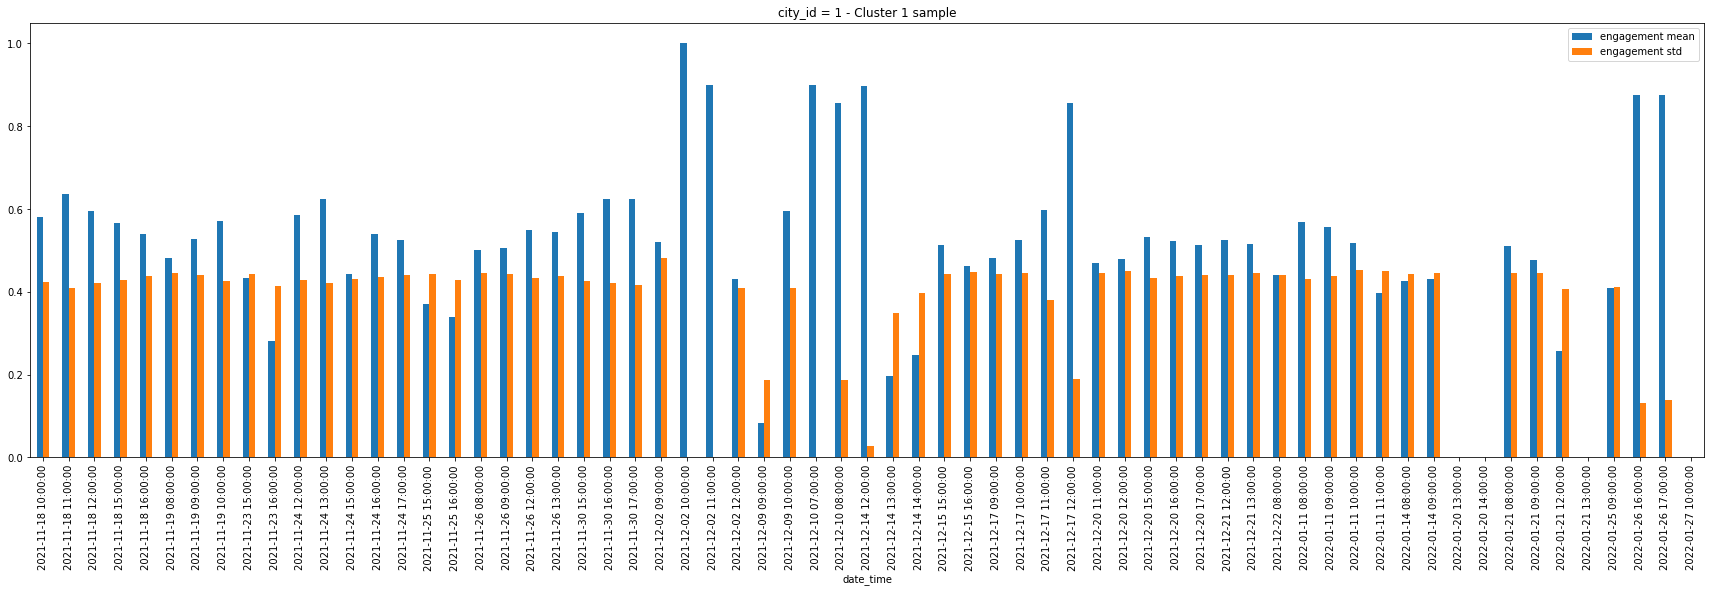

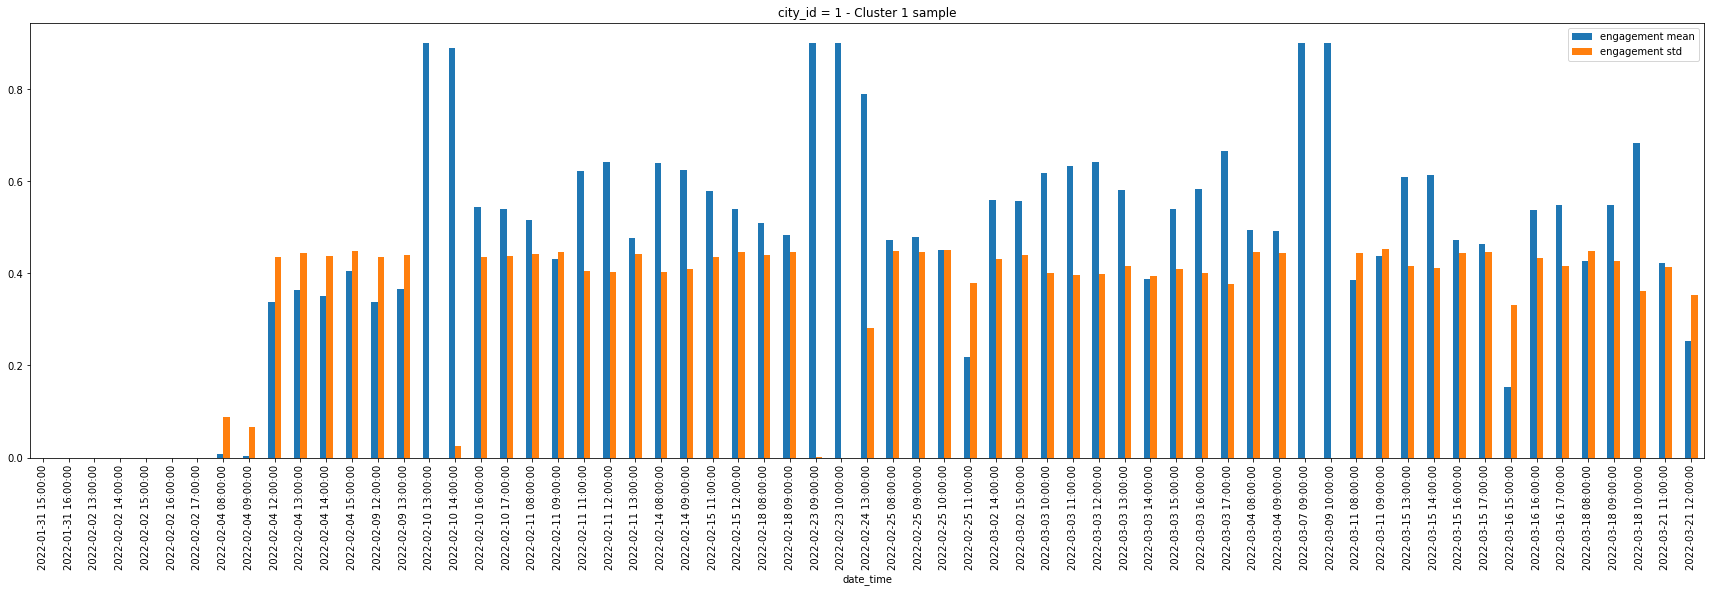

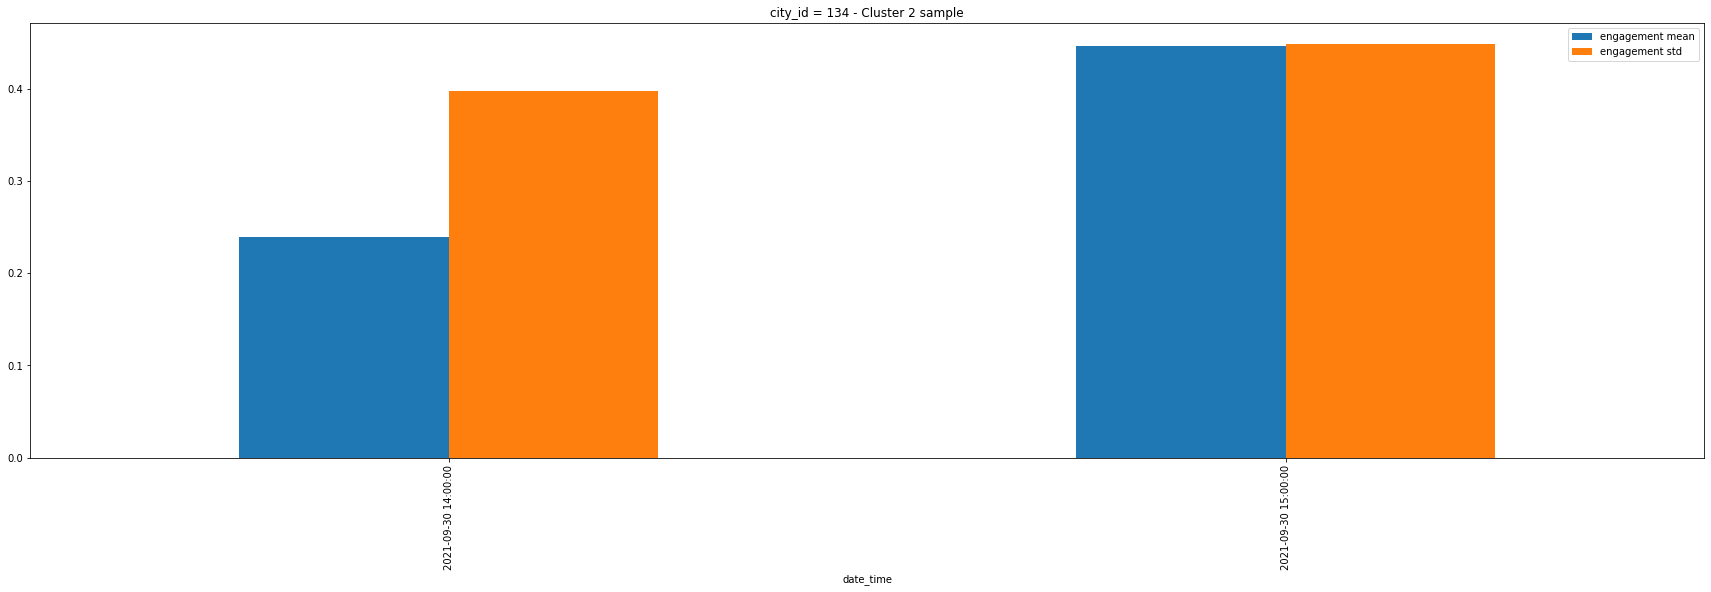

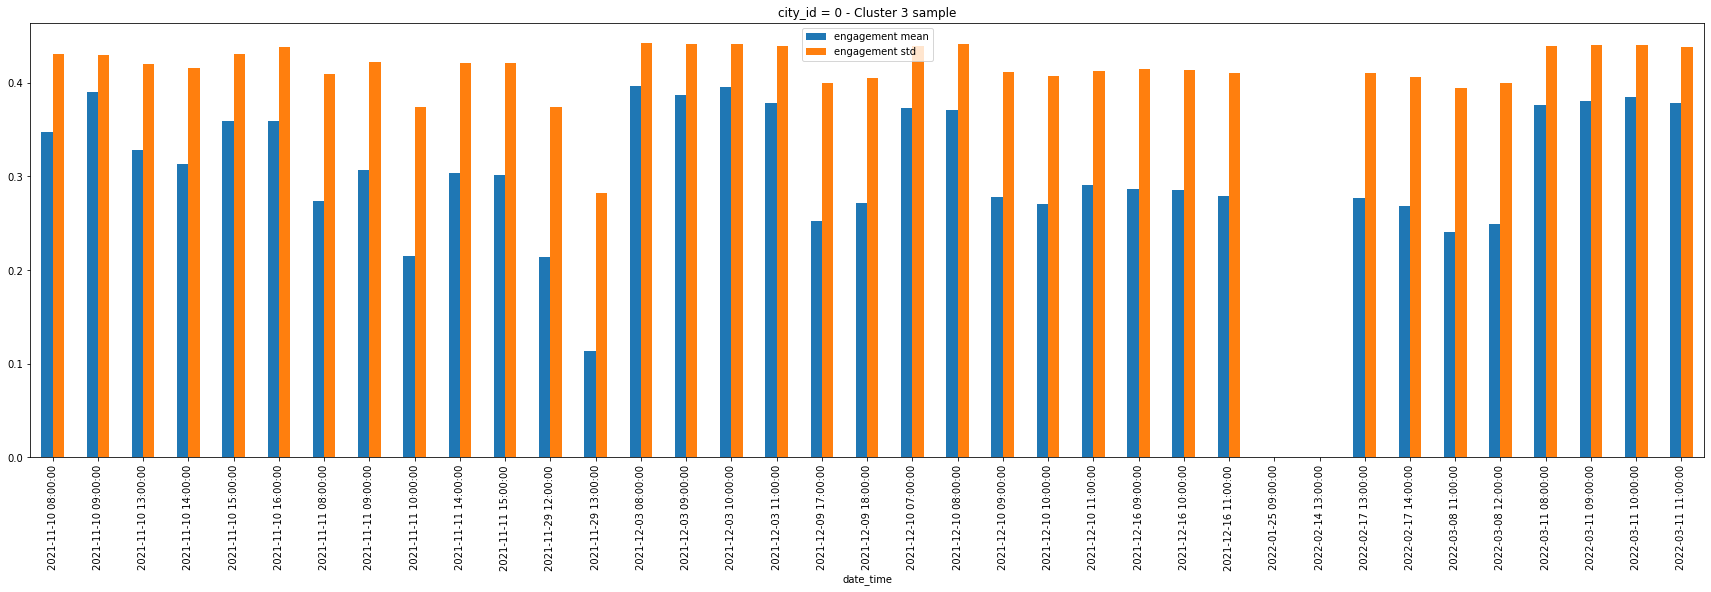

In [ ]:
print("Number of clusters:",cluster_num)
for i in range(cluster_num):
  CityId = np.where(kmeans.labels_==i)[0][0]
  cur = city_list[CityId]

  temp_list = np.array_split(cur, cur.shape[0]/80 + 1)
  for cur_list in temp_list:
    fig, ax = plt.subplots()
    cur_list.plot(kind='bar',figsize=(30,8),title='city_id = {:d} - Cluster {:d} sample'.format(CityId,i),ax=ax)
    ax.legend(["engagement mean", "engagement std"])

# Viewers’ QoE distribution over time

## customer_id

In [ ]:
customer_list = []

for CustomerId in tqdm(range(33),desc="Calculating viewers' qoe distribution..."):
  customer_df = df[df['customer_id'] == CustomerId]
  temp_df = customer_df[['date_time','qoe']]
  temp_df = temp_df.assign(date_time=temp_df.date_time.dt.round('H'))
  temp = temp_df.groupby('date_time').agg([np.mean,np.std])
  customer_list.append(temp)

Calculating viewers' qoe distribution...: 100%|██████████| 33/33 [00:06<00:00,  5.23it/s]


In [ ]:
cos_distance_array = np.zeros((33,33))
x = -1
y = -1

for customer1 in tqdm(customer_list,desc='Calculating the cos distance array...'):
  customer1_data = customer1.iloc[:,0].to_numpy()
  x += 1
  y = -1
  for customer2 in customer_list:
    y += 1
    customer2_data = customer2.iloc[:,0].to_numpy()
    if(x <= y):
      continue
    if len(customer1_data) >= len(customer2_data):
      inp1 = customer1_data
      inp2 = np.pad(customer2_data,(0,len(customer1_data) - len(customer2_data)),'constant')
    else:
      inp1 = np.pad(customer1_data,(0,len(customer2_data) - len(customer1_data)),'constant')
      inp2 = customer2_data
    cos_distance_array[x,y] = spatial.distance.cosine(inp1, inp2)
    cos_distance_array[y,x] = cos_distance_array[x,y]

Calculating the cos distance array...: 100%|██████████| 33/33 [00:00<00:00, 178.78it/s]


In [ ]:
cos_distance_array

array([[0.        , 0.31720494, 0.38680865, ..., 0.15904889, 0.07917143,
        0.54761289],
       [0.31720494, 0.        , 0.10117676, ..., 0.18367249, 0.25380236,
        0.69524347],
       [0.38680865, 0.10117676, 0.        , ..., 0.26549558, 0.32805725,
        0.72386719],
       ...,
       [0.15904889, 0.18367249, 0.26549558, ..., 0.        , 0.08209133,
        0.62260168],
       [0.07917143, 0.25380236, 0.32805725, ..., 0.08209133, 0.        ,
        0.59080424],
       [0.54761289, 0.69524347, 0.72386719, ..., 0.62260168, 0.59080424,
        0.        ]])

In [ ]:
cluster_num = 3
kmeans = KMeans(n_clusters=cluster_num).fit(cos_distance_array)

In [ ]:
kmeans.labels_

array([2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0,
       0, 0, 1, 2, 0, 0, 2, 2, 0, 2, 1], dtype=int32)

Number of clusters: 3


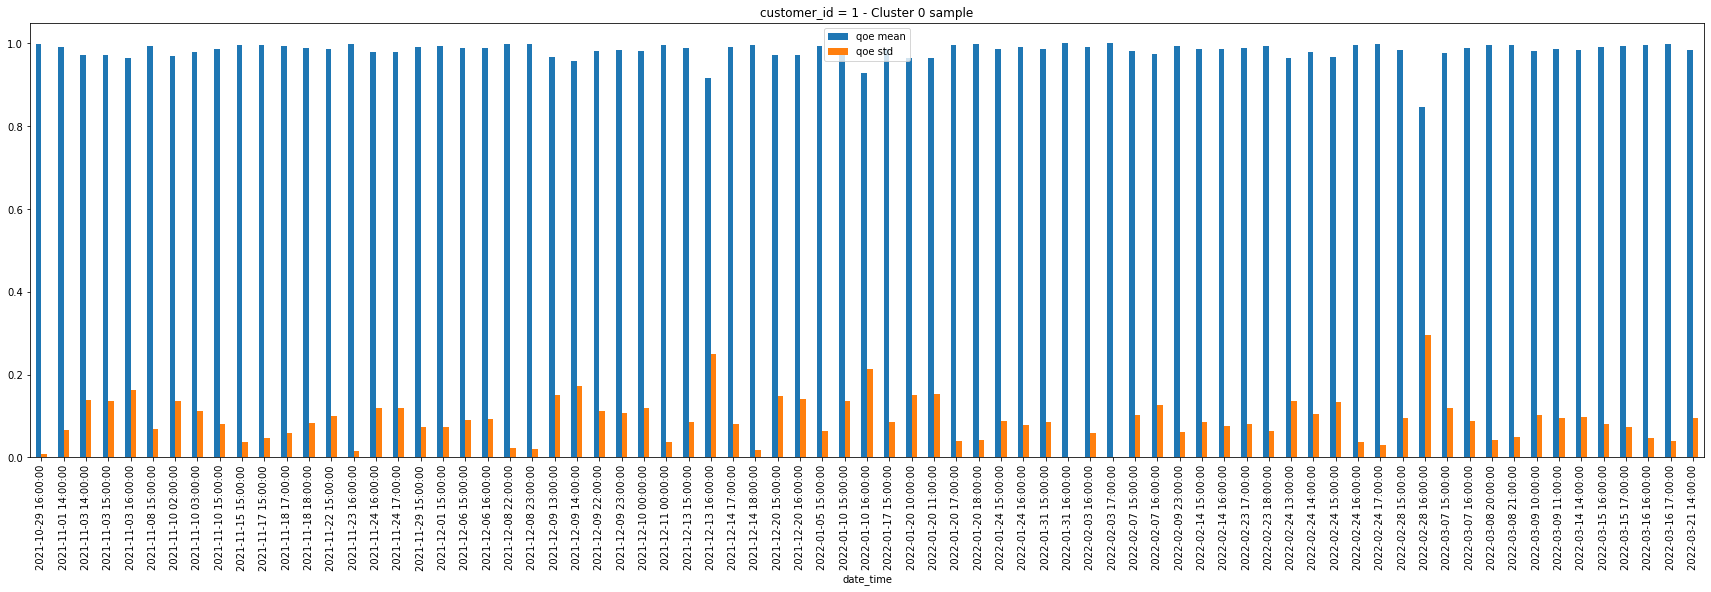

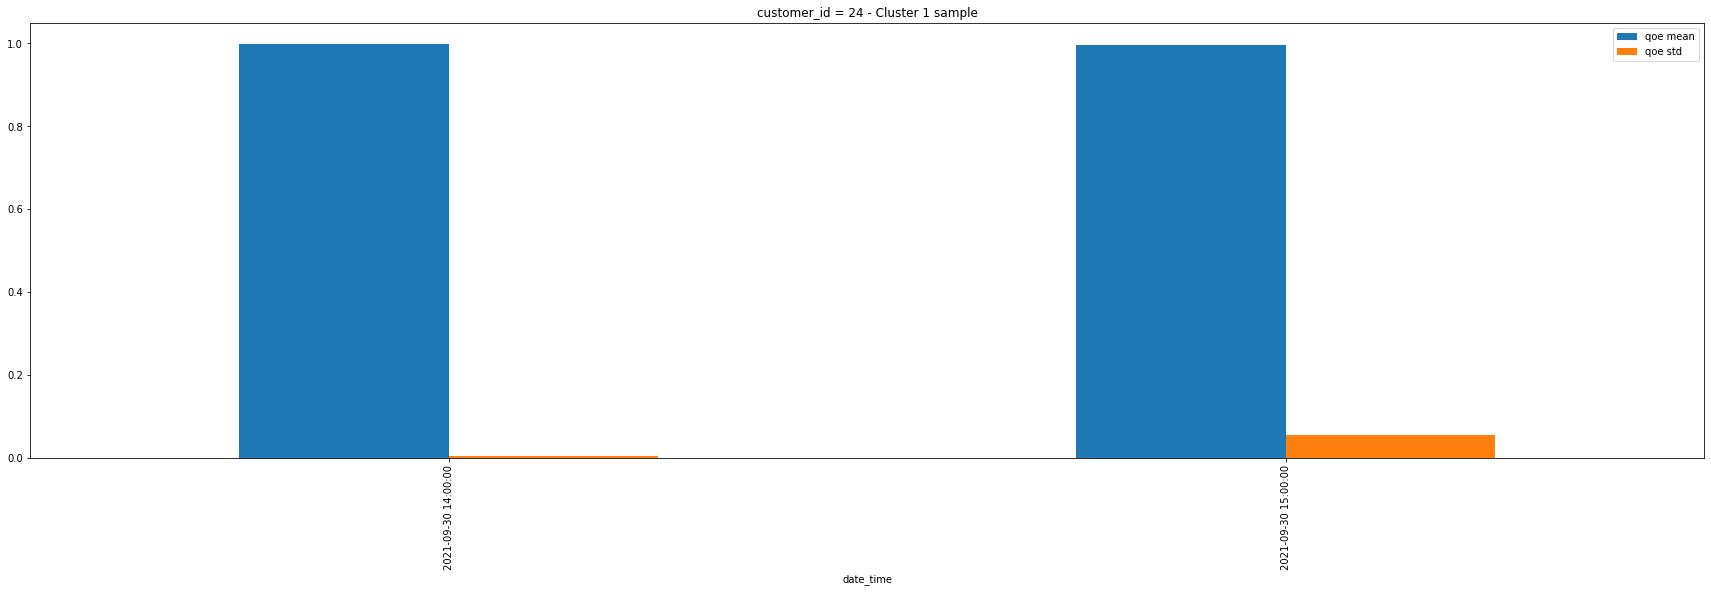

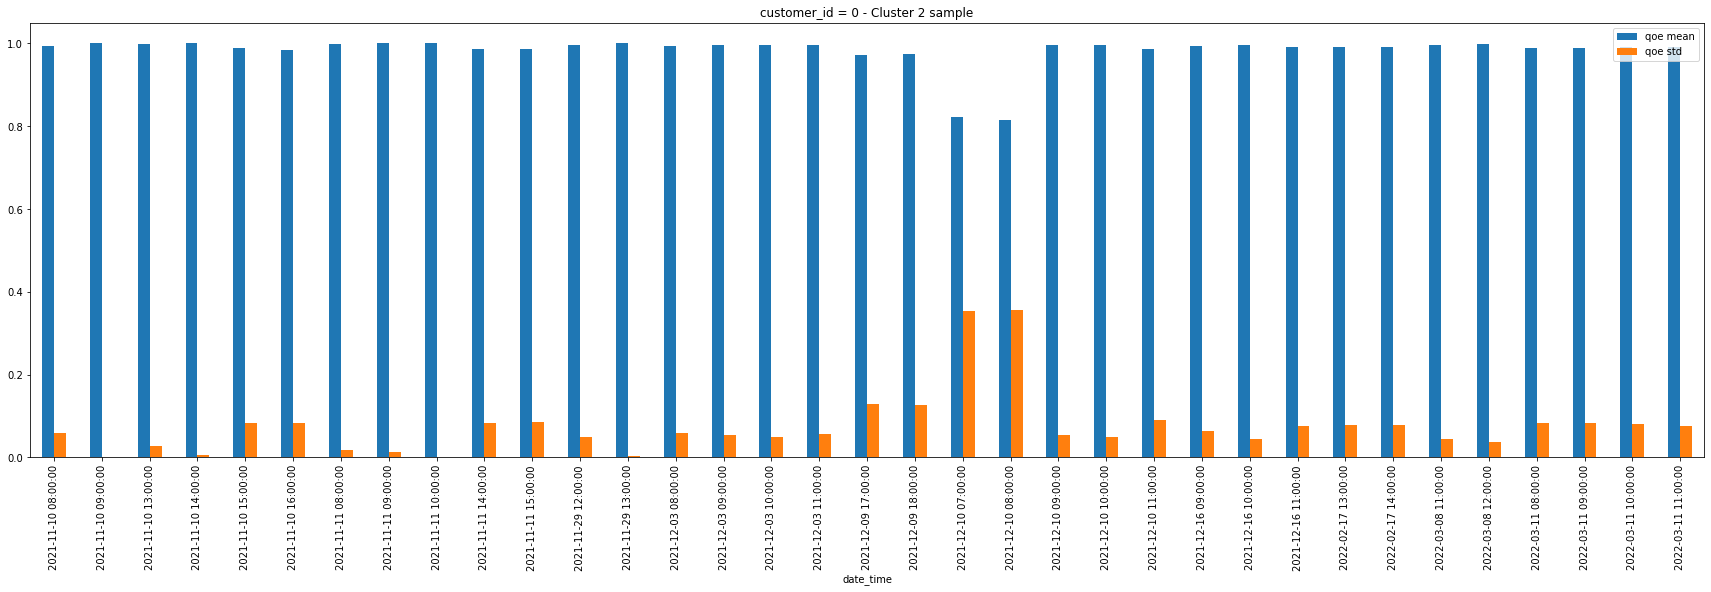

In [ ]:
print("Number of clusters:",cluster_num)
for i in range(cluster_num):
  CustomerId = np.where(kmeans.labels_==i)[0][0]
  cur = customer_list[CustomerId]
  fig, ax = plt.subplots()
  cur.plot(kind='bar',figsize=(30,8),title='customer_id = {:d} - Cluster {:d} sample'.format(CustomerId,i),ax=ax)
  ax.legend(["qoe mean", "qoe std"])

## country_id

In [ ]:
country_list = []

for CountryId in tqdm(range(124),desc="Calculating viewers' qoe distribution..."):
  country_df = df[df['country_id'] == CountryId]
  temp_df = country_df[['date_time','qoe']]
  temp_df = temp_df.assign(date_time=temp_df.date_time.dt.round('H'))
  temp = temp_df.groupby('date_time').agg([np.mean,np.std])
  country_list.append(temp)

Calculating viewers' qoe distribution...: 100%|██████████| 124/124 [00:10<00:00, 12.20it/s]


In [ ]:
cos_distance_array = np.zeros((124,124))
x = -1
y = -1

for country1 in tqdm(country_list,desc='Calculating the cos distance array...'):
  country1_data = country1.iloc[:,0].to_numpy()
  x += 1
  y = -1
  for country2 in country_list:
    y += 1
    country2_data = country2.iloc[:,0].to_numpy()
    if(x <= y):
      continue
    if len(country1_data) >= len(country2_data):
      inp1 = country1_data
      inp2 = np.pad(country2_data,(0,len(country1_data) - len(country2_data)),'constant')
    else:
      inp1 = np.pad(country1_data,(0,len(country2_data) - len(country1_data)),'constant')
      inp2 = country2_data
    if norm(inp1) == 0 or norm(inp2) == 0:
      cos_distance_array[x,y] = 1
      cos_distance_array[y,x] = 1
    else:
      cos_distance_array[x,y] = spatial.distance.cosine(inp1, inp2)
      cos_distance_array[y,x] = cos_distance_array[x,y]

Calculating the cos distance array...: 100%|██████████| 124/124 [00:03<00:00, 39.22it/s]


In [ ]:
cos_distance_array

array([[0.00000000e+00, 2.44744769e-01, 3.62568665e-02, ...,
        9.20162767e-01, 9.20150265e-01, 9.42870106e-01],
       [2.44744769e-01, 0.00000000e+00, 2.72744580e-01, ...,
        9.37940394e-01, 9.37937941e-01, 9.56140173e-01],
       [3.62568665e-02, 2.72744580e-01, 0.00000000e+00, ...,
        9.16381985e-01, 9.16376602e-01, 9.40747075e-01],
       ...,
       [9.20162767e-01, 9.37940394e-01, 9.16381985e-01, ...,
        0.00000000e+00, 4.46534191e-05, 2.99621086e-01],
       [9.20150265e-01, 9.37937941e-01, 9.16376602e-01, ...,
        4.46534191e-05, 0.00000000e+00, 2.92907134e-01],
       [9.42870106e-01, 9.56140173e-01, 9.40747075e-01, ...,
        2.99621086e-01, 2.92907134e-01, 0.00000000e+00]])

In [ ]:
cluster_num = 3
kmeans = KMeans(n_clusters=cluster_num).fit(cos_distance_array)

In [ ]:
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2,
       0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

Number of clusters: 3


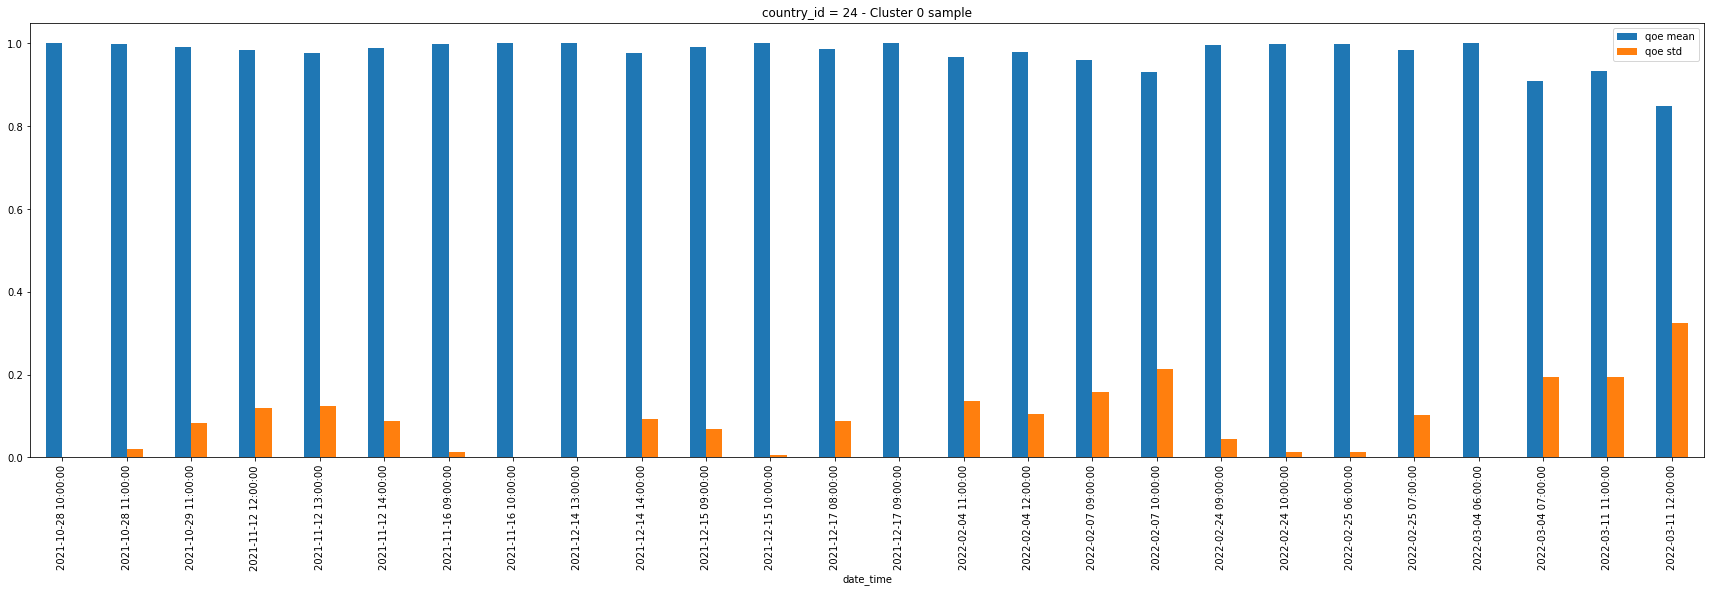

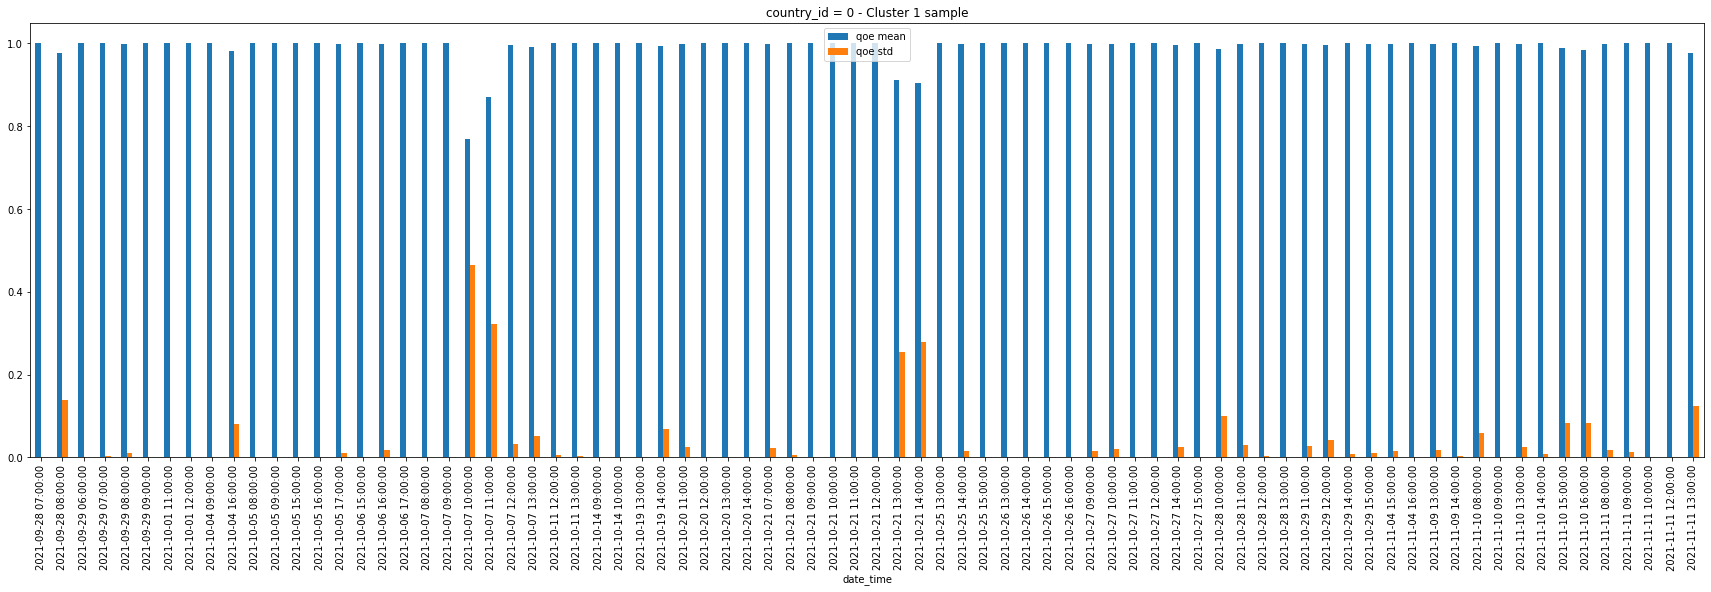

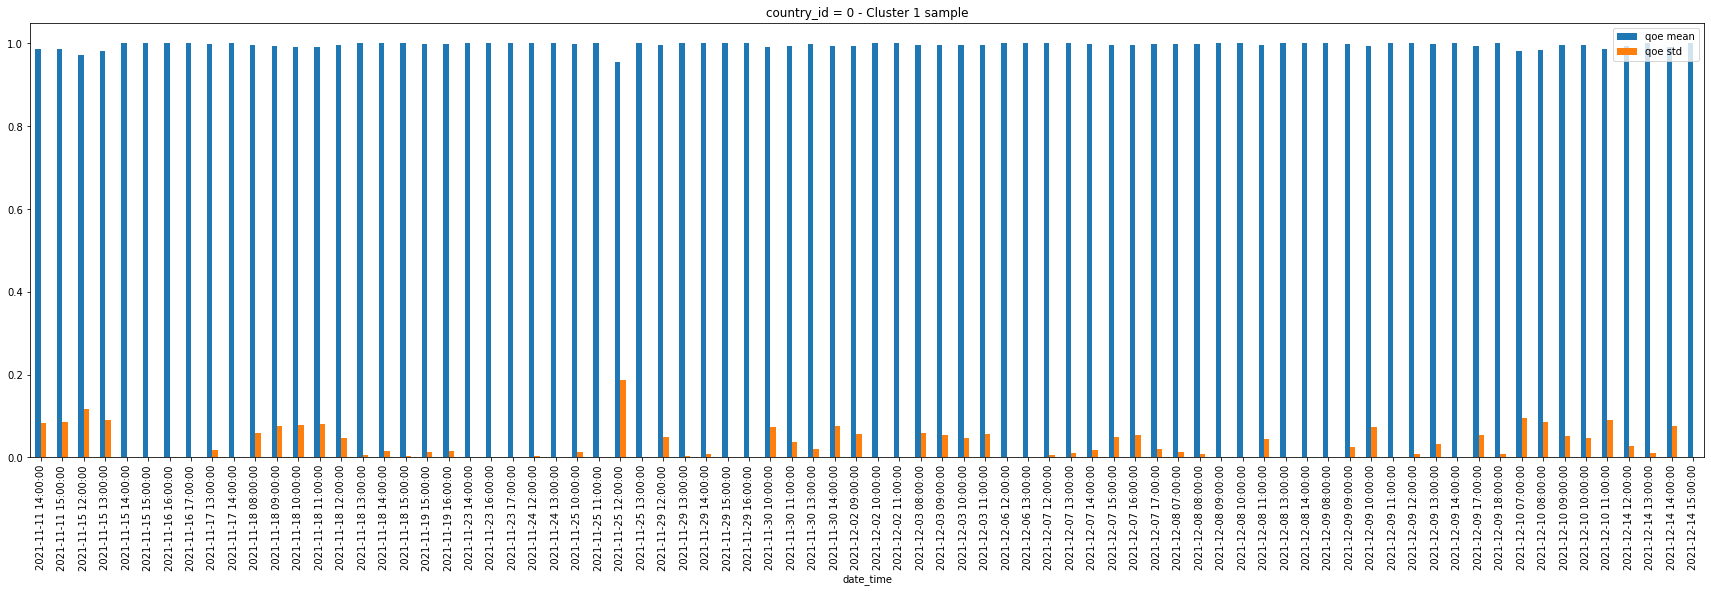

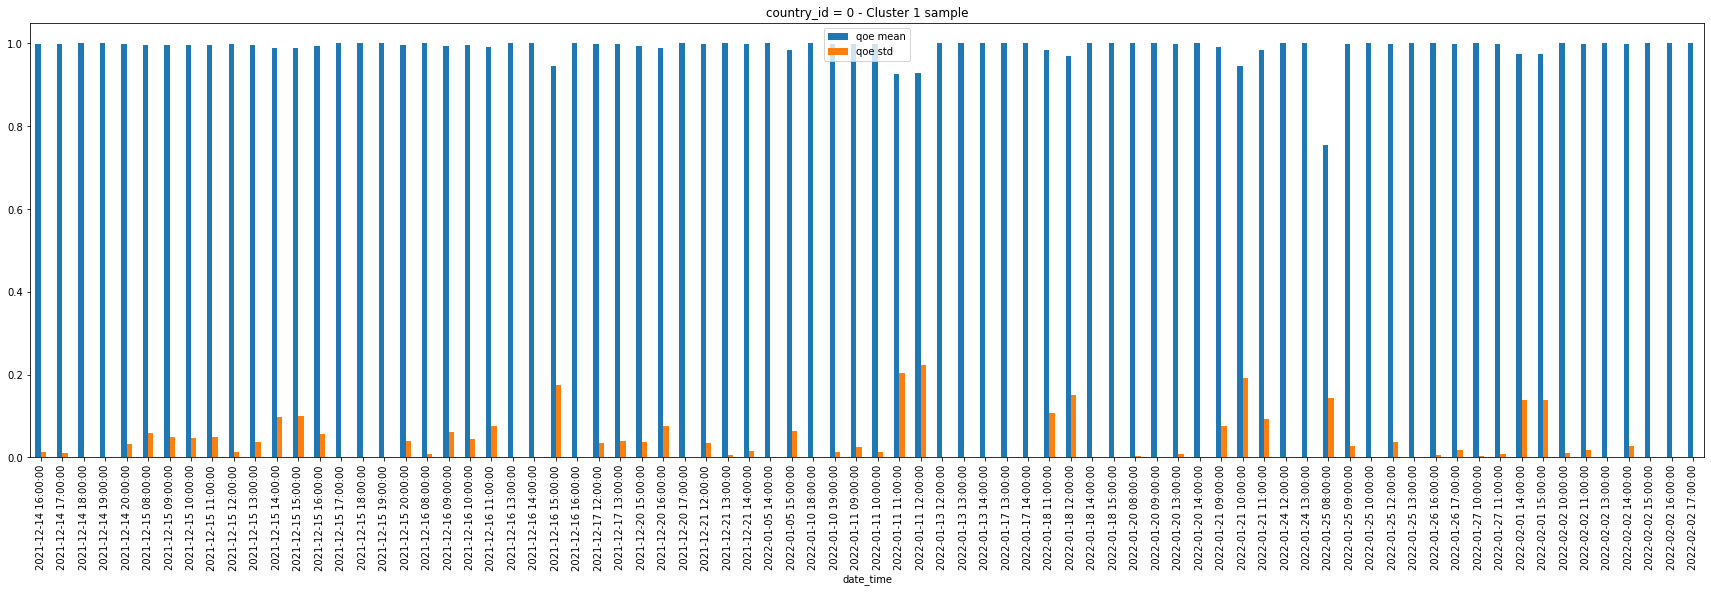

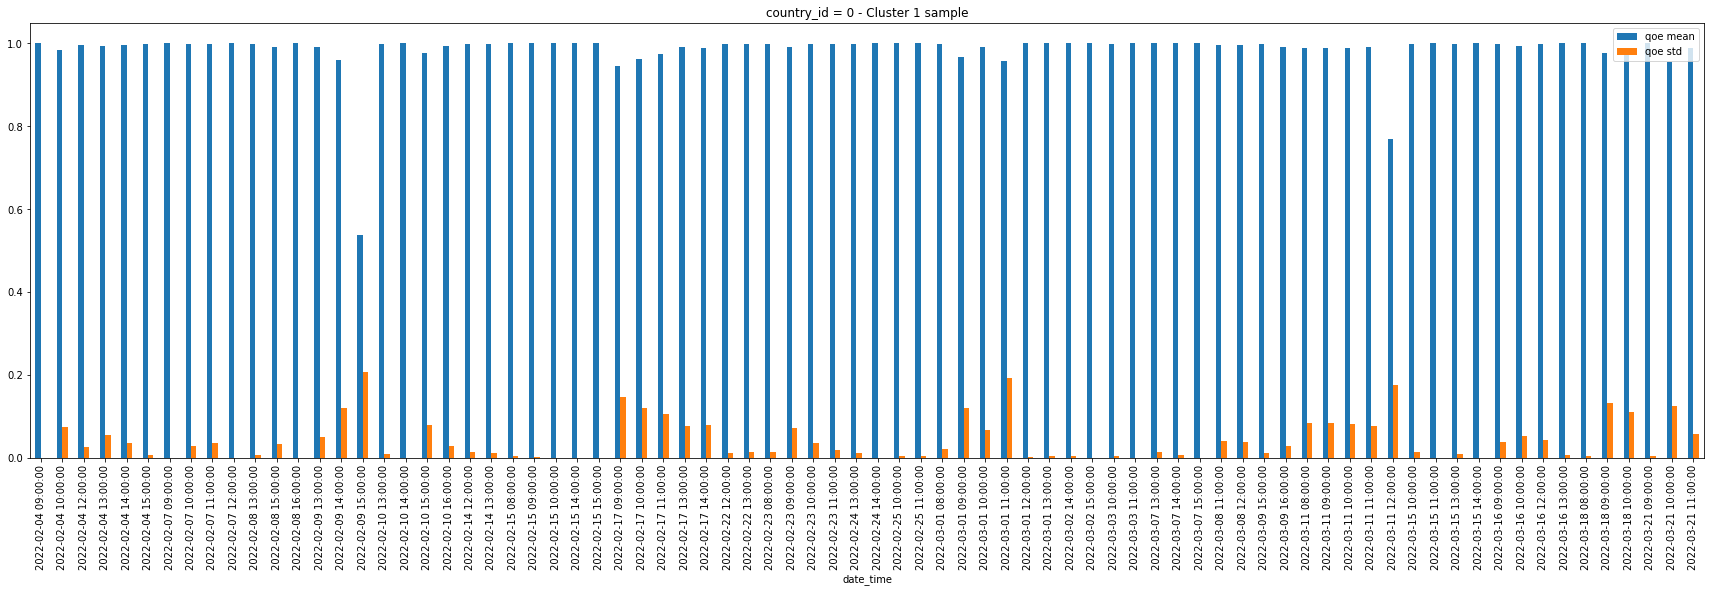

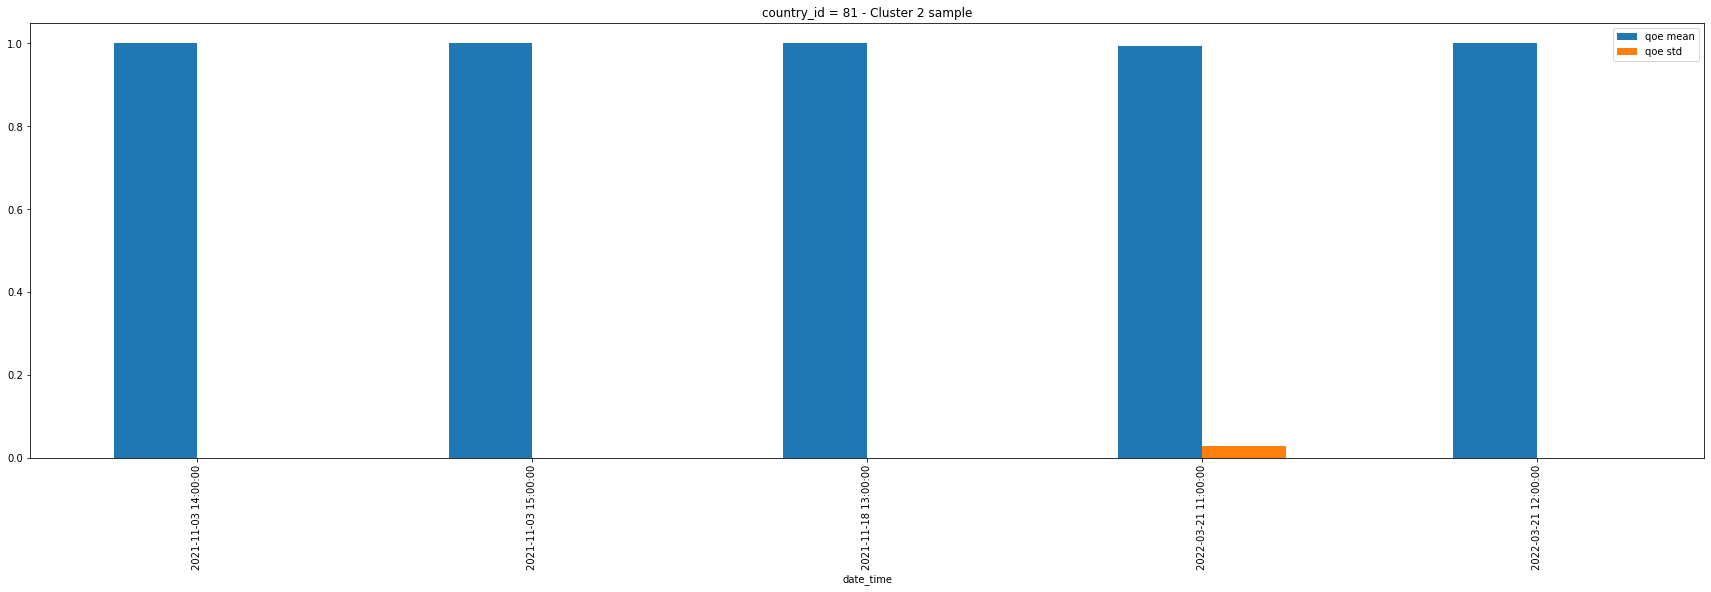

In [ ]:
print("Number of clusters:",cluster_num)
for i in range(cluster_num):
  CountryId = np.where(kmeans.labels_==i)[0][0]
  cur = country_list[CountryId]

  temp_list = np.array_split(cur, cur.shape[0]/80 + 1)
  for cur_list in temp_list:
    fig, ax = plt.subplots()
    cur_list.plot(kind='bar',figsize=(30,8),title='country_id = {:d} - Cluster {:d} sample'.format(CountryId,i),ax=ax)
    ax.legend(["qoe mean", "qoe std"])

## city_id

In [ ]:
city_list = []

for CityId in tqdm(range(8219),desc="Calculating viewers' qoe distribution..."):
  city_df = df[df['city_id'] == CityId]
  temp_df = city_df[['date_time','qoe']]
  temp_df = temp_df.assign(date_time=temp_df.date_time.dt.round('H'))
  temp = temp_df.groupby('date_time').agg([np.mean,np.std])
  city_list.append(temp)

Calculating viewers' qoe distribution...: 100%|██████████| 8219/8219 [06:11<00:00, 22.11it/s]


In [ ]:
cos_distance_array = np.zeros((8219,8219))
x = -1
y = -1

for city1 in tqdm(city_list,desc='Calculating the cos distance array...'):
  city1_data = city1.iloc[:,0].to_numpy()
  x += 1
  y = -1
  for city2 in city_list:
    y += 1
    if(x == y):
      break
    city2_data = city2.iloc[:,0].to_numpy()
    if len(city1_data) >= len(city2_data):
      inp1 = city1_data
      inp2 = np.pad(city2_data,(0,len(city1_data) - len(city2_data)),'constant')
    else:
      inp1 = np.pad(city1_data,(0,len(city2_data) - len(city1_data)),'constant')
      inp2 = city2_data
    if norm(inp1) == 0 or norm(inp2) == 0:
      cos_distance_array[x,y] = 1
      cos_distance_array[y,x] = 1
    else:
      cos_distance_array[x,y] = spatial.distance.cosine(inp1, inp2)
      cos_distance_array[y,x] = cos_distance_array[x,y]

Calculating the cos distance array...: 100%|██████████| 8219/8219 [2:18:51<00:00,  1.01s/it]


In [ ]:
cos_distance_array

array([[0.00000000e+00, 5.64486225e-01, 3.45199011e-01, ...,
        8.35894590e-01, 8.35894590e-01, 8.35894590e-01],
       [5.64486225e-01, 0.00000000e+00, 3.35184581e-01, ...,
        9.27893460e-01, 9.27893460e-01, 9.27893460e-01],
       [3.45199011e-01, 3.35184581e-01, 0.00000000e+00, ...,
        8.92528858e-01, 8.92528858e-01, 8.92528858e-01],
       ...,
       [8.35894590e-01, 9.27893460e-01, 8.92528858e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.35894590e-01, 9.27893460e-01, 8.92528858e-01, ...,
        0.00000000e+00, 0.00000000e+00, 1.11022302e-16],
       [8.35894590e-01, 9.27893460e-01, 8.92528858e-01, ...,
        0.00000000e+00, 1.11022302e-16, 0.00000000e+00]])

In [ ]:
cluster_num = 4
kmeans = KMeans(n_clusters=cluster_num).fit(cos_distance_array)

In [ ]:
kmeans.labels_

array([2, 2, 2, ..., 3, 3, 3], dtype=int32)

Number of clusters: 4


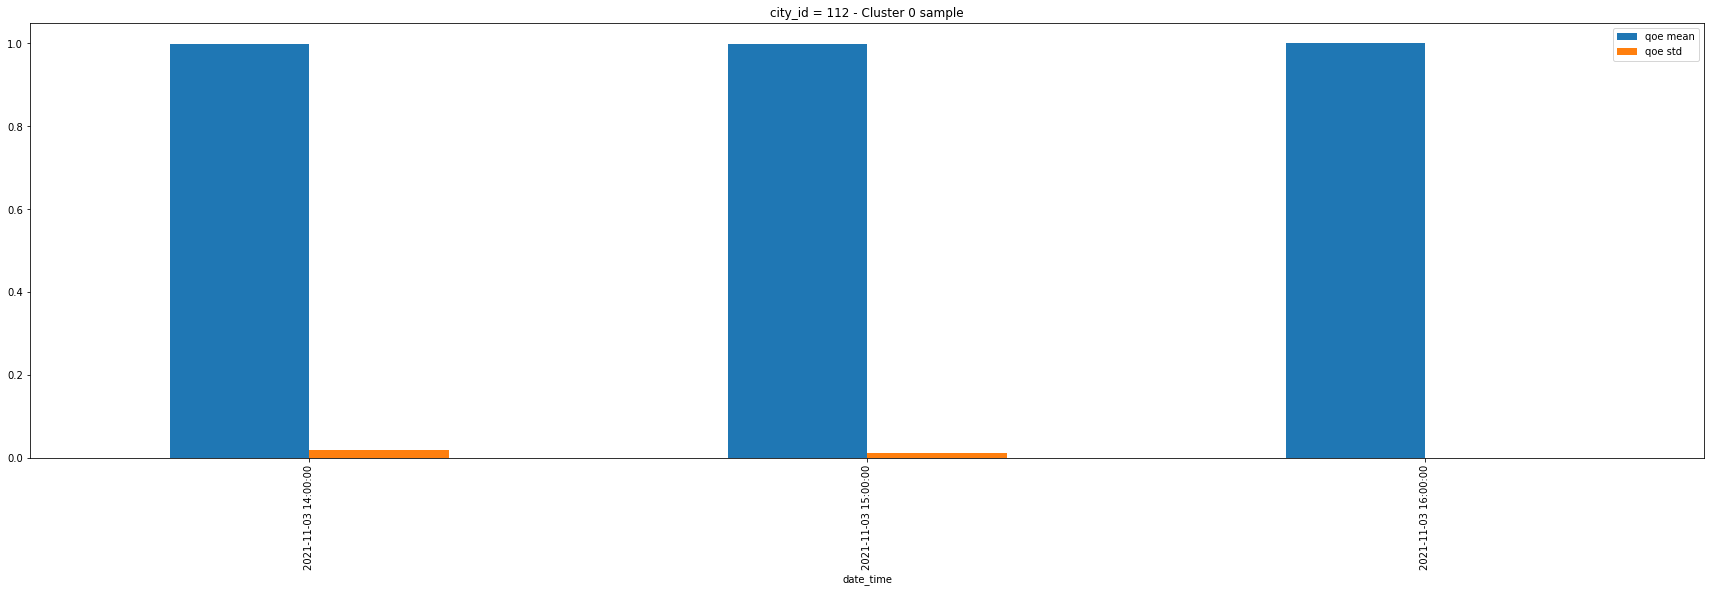

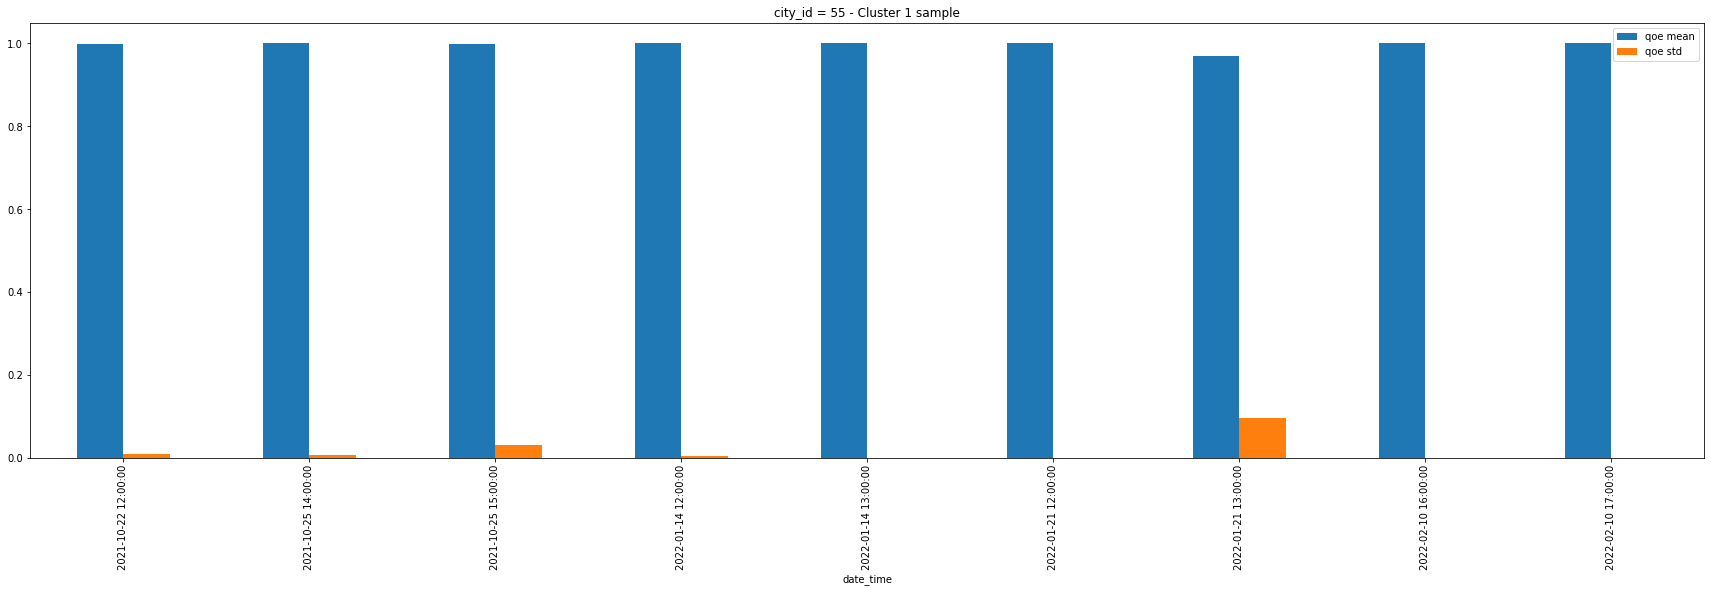

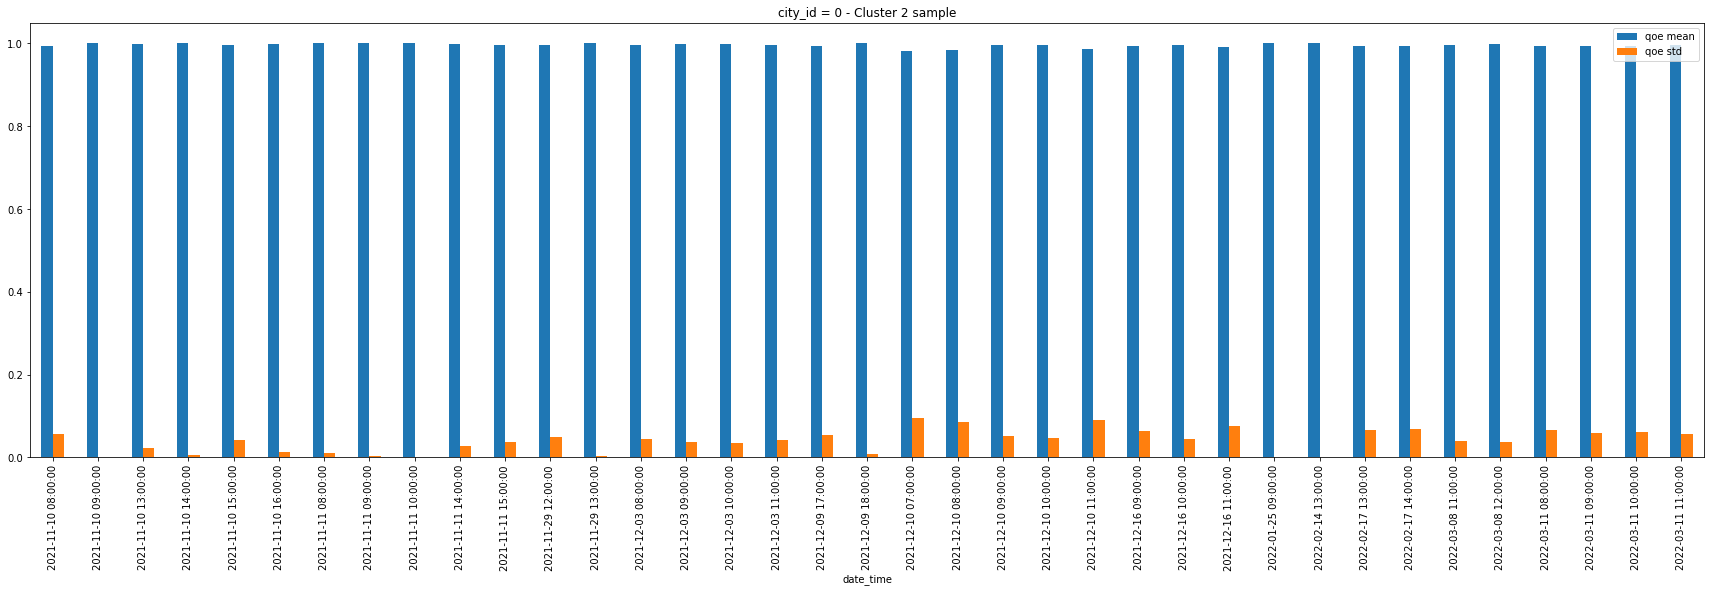

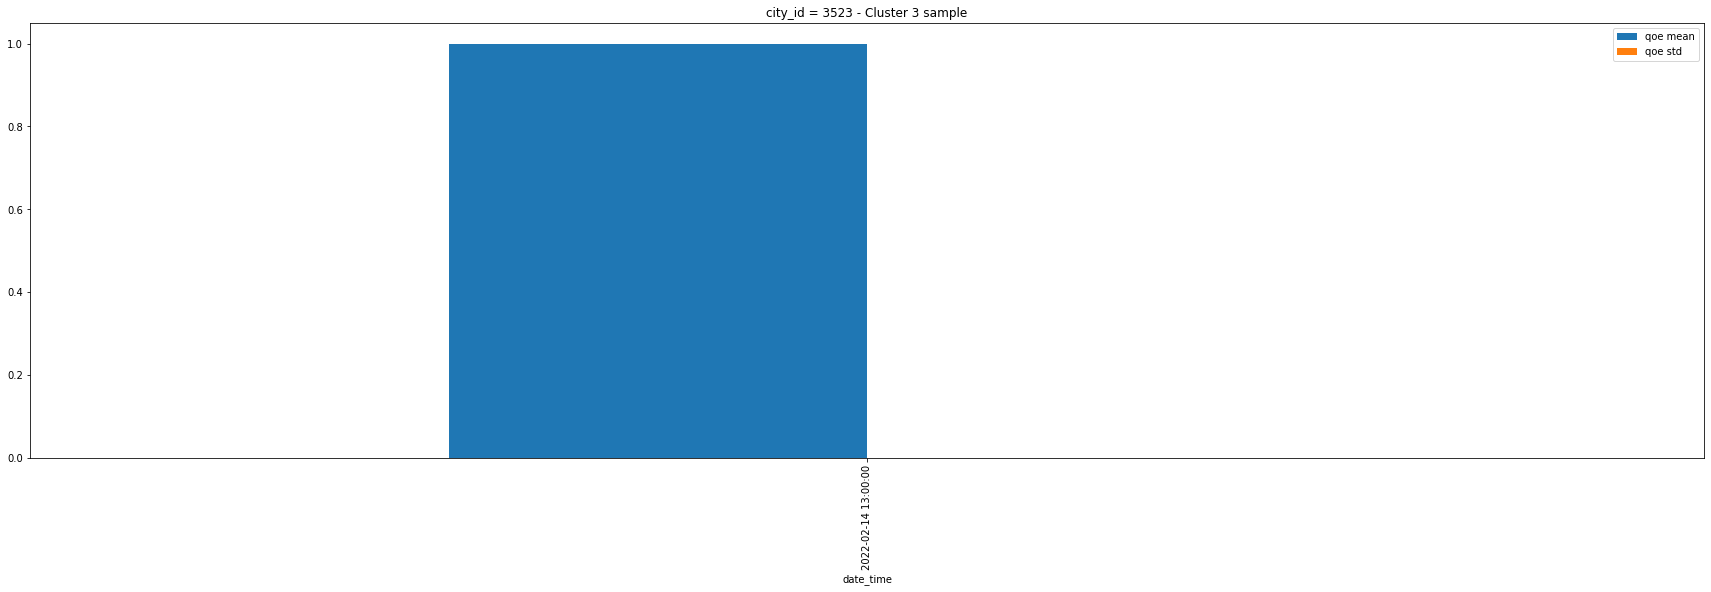

In [ ]:
print("Number of clusters:",cluster_num)
for i in range(cluster_num):
  CityId = np.where(kmeans.labels_==i)[0][0]
  cur = city_list[CityId]

  temp_list = np.array_split(cur, cur.shape[0]/80 + 1)
  for cur_list in temp_list:
    fig, ax = plt.subplots()
    cur_list.plot(kind='bar',figsize=(30,8),title='city_id = {:d} - Cluster {:d} sample'.format(CityId,i),ax=ax)
    ax.legend(["qoe mean", "qoe std"])

# Viewers’ engagement/QoE distribution differences based on the viewer type parameter

In [ ]:
df_wfo = df[df['viewer_type'] == 'WFO']
df_wfh = df[df['viewer_type'] == 'WFH']

## Comparison of mean and standard deviation

In [ ]:
print("="*10 + "ENGAGEMENT DISTRIBUTIONS COMPARISON" + "="*10)
print("Work from office: mean =",df_wfo.engagement.mean(),", std =",df_wfo.engagement.std())
print("Work from home: mean =",df_wfh.engagement.mean(),", std =",df_wfh.engagement.std())

print("="*10 + "QOE DISTRIBUTIONS COMPARISON" + "="*10)
print("Work from office: mean =",df_wfo.qoe.mean(),", std =",df_wfo.qoe.std())
print("Work from home: mean =",df_wfh.qoe.mean(),", std =",df_wfh.qoe.std())

==========ENGAGEMENT DISTRIBUTIONS COMPARISON==========
Work from office: mean = 0.4309373382365679 , std = 0.4458737037751291
Work from home: mean = 0.4603648789913582 , std = 0.4461841694444893
==========QOE DISTRIBUTIONS COMPARISON==========
Work from office: mean = 0.9835013448109539 , std = 0.09993508463998182
Work from home: mean = 0.9856780948603949 , std = 0.09389173828561506


## Kolmogorov–Smirnov test

In [ ]:
from scipy.stats import ks_2samp

print("="*10 + "KOLMOGOROV-SMIRNOV TEST" + "="*10)
print("Engagement distributions statistic: ",ks_2samp(df_wfo['engagement'],df_wfh['engagement']).statistic)
print("Qoe distributions statistic: ",ks_2samp(df_wfo['qoe'],df_wfh['qoe']).statistic)

==========KOLMOGOROV-SMIRNOV TEST==========
Engagement distributions statistic:  0.034261164234109076
Qoe distributions statistic:  0.005499359059944611


From the above I come to a couple of conclusions:
1. The average engagement is a little higher when working from home.

2. The viewer type plays hardly any role when it comes to the qoe distributions.


# Viewers’ engagement level duration

I define 4 engagement levels:
1. low: engagement <= 0.1
2. quite low: 0.1 < engagement <= 0.5
3. quite high: 0.5 < engagement <= 0.8
3. high: engagement > 0.8

and insert the respective feature in a dataframe.

In [ ]:
eng_level_df = df.assign(date_time=df.date_time.dt.round('0.5min'))
eng_level_df.viewer_type.replace({"WFO": 0, "WFH": 1},inplace=True)

In [ ]:
eng_level_df.loc[eng_level_df['engagement'] <= 0.1,'engagement_level'] = 'low'
eng_level_df.loc[eng_level_df['engagement'] > 0.1,'engagement_level'] = 'quite low'
eng_level_df.loc[eng_level_df['engagement'] > 0.5,'engagement_level'] = 'quite high'
eng_level_df.loc[eng_level_df['engagement'] > 0.8,'engagement_level'] = 'high'
eng_level_df.head()

,Unnamed: 0,timestamp,customer_id,event_id,viewer_id,city_id,country_id,viewer_type,qoe,engagement,date_time,engagement_level
0,0,1632762065906,5.0,107.0,11661.0,2.0,3.0,0,0.999976,0.0,2021-09-27 17:01:00,low
1,19,1632762104254,5.0,107.0,12810.0,2.0,3.0,1,0.281964,0.9,2021-09-27 17:01:30,high
2,40,1632762108299,5.0,107.0,15129.0,19.0,3.0,1,1.000000,0.9,2021-09-27 17:02:00,high
3,55,1632762112510,5.0,107.0,5860.0,217.0,3.0,1,0.999988,0.0,2021-09-27 17:02:00,low
4,78,1632762129231,5.0,107.0,4483.0,2.0,3.0,0,1.000000,0.0,2021-09-27 17:02:00,low


In the following subsections I calculate the ratio of every engagement level splitting the dataframe with respect to the features 'country_id', 'city_id' and 'viewer_type'.

## Country

In [ ]:
eng_level_ratio_df = pd.DataFrame(columns = ['country_id','low_engagement_ratio','quite_low_engagement_ratio','quite_high_engagement_ratio','high_engagement_ratio'])

for cur_id in tqdm(range(124)):
  df_country = eng_level_df[eng_level_df['country_id'] == cur_id]
  data_rows_num = df_country.shape[0]
  low_engagement_rows = df_country[df_country['engagement_level'] == 'low'].shape[0]
  quite_low_engagement_rows = df_country[df_country['engagement_level'] == 'quite low'].shape[0]
  quite_high_engagement_rows = df_country[df_country['engagement_level'] == 'quite high'].shape[0]
  high_engagement_rows = df_country[df_country['engagement_level'] == 'high'].shape[0]
  low_engagement_ratio = low_engagement_rows/data_rows_num
  quite_low_engagement_ratio = quite_low_engagement_rows/data_rows_num
  quite_high_engagement_ratio = quite_high_engagement_rows/data_rows_num
  high_engagement_ratio = high_engagement_rows/data_rows_num
  temp_df = pd.DataFrame({'country_id':[cur_id],'low_engagement_ratio':[low_engagement_ratio],'quite_low_engagement_ratio':[quite_low_engagement_ratio],
                         'quite_high_engagement_ratio':[quite_high_engagement_ratio],'high_engagement_ratio':[high_engagement_ratio]})
  eng_level_ratio_df = eng_level_ratio_df.append(temp_df)

100%|██████████| 124/124 [00:15<00:00,  7.99it/s]


I present the engagement level ratios for a sample of 6 countries:

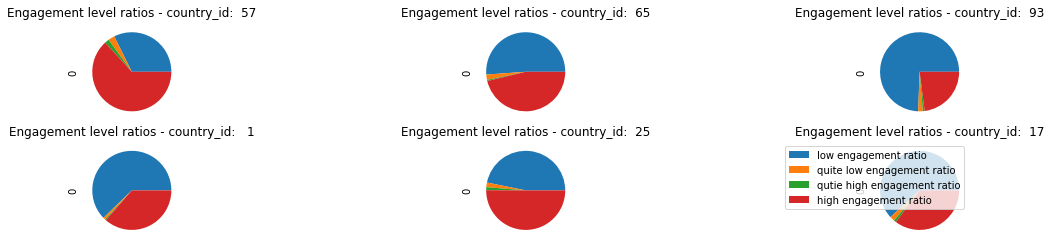

In [ ]:
sample_countries = sample(range(0, 123), 6)
index = -1
fig, axes = plt.subplots(2, 3)
for CountryId in sample_countries:
  index += 1
  eng_level_ratio_df.iloc[CountryId].drop(['country_id']).plot(kind='pie',figsize=(20,4),labels = None,title='Engagement level ratios - country_id: {:3d}'.format(CountryId),ax = axes[int(index/3),index%3])
  plt.legend(['low engagement ratio','quite low engagement ratio','qutie high engagement ratio','high engagement ratio'],loc = 'best')
plt.show() 
  

## City

In [ ]:
eng_level_ratio_df = pd.DataFrame(columns = ['city_id','low_engagement_ratio','quite_low_engagement_ratio','quite_high_engagement_ratio','high_engagement_ratio'])

for cur_id in tqdm(range(8219)):
  df_city = eng_level_df[eng_level_df['city_id'] == cur_id]
  data_rows_num = df_city.shape[0]
  low_engagement_rows = df_city[df_city['engagement_level'] == 'low'].shape[0]
  quite_low_engagement_rows = df_city[df_city['engagement_level'] == 'quite low'].shape[0]
  quite_high_engagement_rows = df_city[df_city['engagement_level'] == 'quite high'].shape[0]
  high_engagement_rows = df_city[df_city['engagement_level'] == 'high'].shape[0]
  low_engagement_ratio = low_engagement_rows/data_rows_num
  quite_low_engagement_ratio = quite_low_engagement_rows/data_rows_num
  quite_high_engagement_ratio = quite_high_engagement_rows/data_rows_num
  high_engagement_ratio = high_engagement_rows/data_rows_num
  temp_df = pd.DataFrame({'city_id':[cur_id],'low_engagement_ratio':[low_engagement_ratio],'quite_low_engagement_ratio':[quite_low_engagement_ratio],
                         'quite_high_engagement_ratio':[quite_high_engagement_ratio],'high_engagement_ratio':[high_engagement_ratio]})
  eng_level_ratio_df = eng_level_ratio_df.append(temp_df)

100%|██████████| 8219/8219 [09:06<00:00, 15.05it/s]


I present the engagement level ratios for a sample of 8 cities:

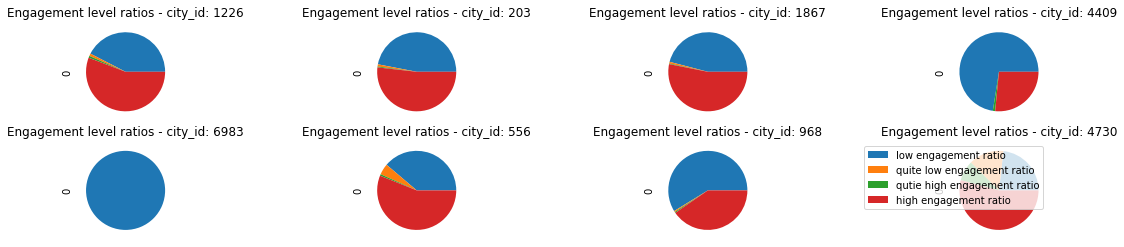

In [ ]:
sample_cities = sample(range(0, 8218), 8)
index = -1
fig, axes = plt.subplots(2, 4)
for CityId in sample_cities:
  index += 1
  eng_level_ratio_df.iloc[CityId].drop(['city_id']).plot(kind='pie',figsize=(20,4),labels = None,title='Engagement level ratios - city_id: {:3d}'.format(CityId),ax = axes[int(index/4),index%4])
  plt.legend(['low engagement ratio','quite low engagement ratio','qutie high engagement ratio','high engagement ratio'],loc = 'best')
plt.show() 

## viewer_type

In [ ]:
eng_level_ratio_df = pd.DataFrame(columns = ['viewer_type','low_engagement_ratio','quite_low_engagement_ratio','quite_high_engagement_ratio','high_engagement_ratio'])

for cur in tqdm(range(2)):
  viewer_type_df = eng_level_df[eng_level_df['viewer_type'] == cur]
  data_rows_num = viewer_type_df.shape[0]
  low_engagement_rows = viewer_type_df[viewer_type_df['engagement_level'] == 'low'].shape[0]
  quite_low_engagement_rows = viewer_type_df[viewer_type_df['engagement_level'] == 'quite low'].shape[0]
  quite_high_engagement_rows = viewer_type_df[viewer_type_df['engagement_level'] == 'quite high'].shape[0]
  high_engagement_rows = viewer_type_df[viewer_type_df['engagement_level'] == 'high'].shape[0]
  low_engagement_ratio = low_engagement_rows/data_rows_num
  quite_low_engagement_ratio = quite_low_engagement_rows/data_rows_num
  quite_high_engagement_ratio = quite_high_engagement_rows/data_rows_num
  high_engagement_ratio = high_engagement_rows/data_rows_num
  temp_df = pd.DataFrame({'viewer_type':[cur],'low_engagement_ratio':[low_engagement_ratio],'quite_low_engagement_ratio':[quite_low_engagement_ratio],
                         'quite_high_engagement_ratio':[quite_high_engagement_ratio],'high_engagement_ratio':[high_engagement_ratio]})
  eng_level_ratio_df = eng_level_ratio_df.append(temp_df)

100%|██████████| 2/2 [00:16<00:00,  8.31s/it]


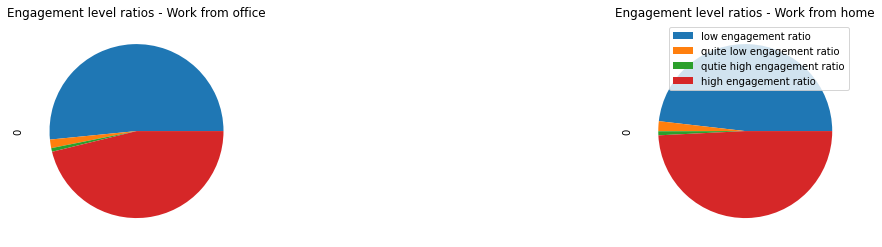

In [ ]:
fig, axes = plt.subplots(1, 2)
eng_level_ratio_df.iloc[0].drop(['viewer_type']).plot(kind='pie',figsize=(20,4),labels = None,title='Engagement level ratios - Work from office',ax = axes[0])
eng_level_ratio_df.iloc[1].drop(['viewer_type']).plot(kind='pie',figsize=(20,4),labels = None,title='Engagement level ratios - Work from home',ax = axes[1])
plt.legend(['low engagement ratio','quite low engagement ratio','qutie high engagement ratio','high engagement ratio'],loc = 'best')
plt.show()

# Countries/Cities that follow different distributions per customer

The criterion used to calculate the difference between the distributions is the Kolmogorov–Smirnov test. For every country/city I compute the average difference between the distributions of all possible customer couples. The results are used then to sort the different countries/cities. 

## Different engagement distributions

### Countries

In [ ]:
country_engagement_difference_df = pd.DataFrame(columns = ['country_id','mean_distr_difference'])

for CountryId in tqdm(range(124)):
  country_df = df[df['country_id'] == CountryId]
  unique_customers_num = country_df.customer_id.nunique()
  customer_array = country_df.customer_id.unique()
  lst = []
  for i in range(unique_customers_num):
    df1 = country_df[country_df['customer_id'] == customer_array[i]]
    for j in range(i+1,unique_customers_num):
      df2 = country_df[country_df['customer_id'] == customer_array[j]]
      lst.append(ks_2samp(df1['engagement'],df2['engagement']).statistic)
  if len(lst) > 0:
    df_next = pd.DataFrame({'country_id':[CountryId],'mean_distr_difference':[sum(lst) / len(lst)]})
    country_engagement_difference_df = country_engagement_difference_df.append(df_next)

country_engagement_difference_df = country_engagement_difference_df.sort_values('mean_distr_difference',ascending = False)
print("\n"+"COUNTRIES WITH THE HIGHEST ENGAGEMENT DIFFERENCES")
country_engagement_difference_df.head()

100%|██████████| 124/124 [03:02<00:00,  1.47s/it]


COUNTRIES WITH THE HIGHEST ENGAGEMENT DIFFERENCES


,country_id,mean_distr_difference
0,110,1.000000
0,79,1.000000
0,97,0.909910
0,48,0.683515
0,81,0.674107


### Cities

In [ ]:
city_engagement_difference_df = pd.DataFrame(columns = ['city_id','mean_distr_difference'])

for CityId in tqdm(range(8243)):
  city_df = df[df['city_id'] == CityId]
  unique_customers_num = city_df.customer_id.nunique()
  customer_array = city_df.customer_id.unique()
  lst = []
  for i in range(unique_customers_num):
    df1 = city_df[city_df['customer_id'] == customer_array[i]]
    for j in range(i+1,unique_customers_num):
      df2 = city_df[city_df['customer_id'] == customer_array[j]]
      lst.append(ks_2samp(df1['engagement'],df2['engagement']).statistic)
  if len(lst) > 0:
    df_next = pd.DataFrame({'city_id':[CityId],'mean_distr_difference':[sum(lst) / len(lst)]})
    city_engagement_difference_df = city_engagement_difference_df.append(df_next)

city_engagement_difference_df = city_engagement_difference_df.sort_values('mean_distr_difference',ascending = False)
print("\n"+"CITIES WITH THE HIGHEST ENGAGEMENT DIFFERENCES")
city_engagement_difference_df.head()

100%|██████████| 8243/8243 [09:42<00:00, 14.16it/s]


CITIES WITH THE HIGHEST ENGAGEMENT DIFFERENCES


,city_id,mean_distr_difference
0,8207,1.0
0,4330,1.0
0,4248,1.0
0,4234,1.0
0,4222,1.0


## Different qoe distributions

### Countries

In [ ]:
country_qoe_difference_df = pd.DataFrame(columns = ['country_id','mean_distr_difference'])

for CountryId in tqdm(range(124)):
  country_df = df[df['country_id'] == CountryId]
  unique_customers_num = country_df.customer_id.nunique()
  customer_array = country_df.customer_id.unique()
  lst = []
  for i in range(unique_customers_num):
    df1 = country_df[country_df['customer_id'] == customer_array[i]]
    for j in range(i+1,unique_customers_num):
      df2 = country_df[country_df['customer_id'] == customer_array[j]]
      lst.append(ks_2samp(df1['qoe'],df2['qoe']).statistic)
  if len(lst) > 0:
    df_next = pd.DataFrame({'country_id':[CountryId],'mean_distr_difference':[sum(lst) / len(lst)]})
    country_qoe_difference_df = country_qoe_difference_df.append(df_next)

country_qoe_difference_df = country_qoe_difference_df.sort_values('mean_distr_difference',ascending = False)
print("\n"+"COUNTRIES WITH THE HIGHEST QOE DIFFERENCES")
country_qoe_difference_df.head()

100%|██████████| 124/124 [02:50<00:00,  1.38s/it]


COUNTRIES WITH THE HIGHEST QOE DIFFERENCES


,country_id,mean_distr_difference
0,79,0.997436
0,89,0.679271
0,26,0.649824
0,80,0.605355
0,58,0.558378


### Cities

In [ ]:
city_qoe_difference_df = pd.DataFrame(columns = ['city_id','mean_distr_difference'])

for CityId in tqdm(range(8243)):
  city_df = df[df['city_id'] == CityId]
  unique_customers_num = city_df.customer_id.nunique()
  customer_array = city_df.customer_id.unique()
  lst = []
  for i in range(unique_customers_num):
    df1 = city_df[city_df['customer_id'] == customer_array[i]]
    for j in range(i+1,unique_customers_num):
      df2 = city_df[city_df['customer_id'] == customer_array[j]]
      lst.append(ks_2samp(df1['qoe'],df2['qoe']).statistic)
  if len(lst) > 0:
    df_next = pd.DataFrame({'city_id':[CityId],'mean_distr_difference':[sum(lst) / len(lst)]})
    city_qoe_difference_df = city_qoe_difference_df.append(df_next)

city_qoe_difference_df = city_qoe_difference_df.sort_values('mean_distr_difference',ascending = False)
print("\n"+"CITIES WITH THE HIGHEST QOE DIFFERENCES")
city_qoe_difference_df.head()

100%|██████████| 8243/8243 [10:28<00:00, 13.13it/s]


CITIES WITH THE HIGHEST QOE DIFFERENCES


,city_id,mean_distr_difference
0,8207,1.0
0,8051,1.0
0,6140,1.0
0,2651,1.0
0,3932,1.0


# Correlations between the data points

The correlations of the features customer_id, event_id, viewer_id, city_id and country_id are pointless, so I do not calculate them.

For the continuous variables 'timestamp', 'qoe', 'engagement' and 'buffer_ms', the correlation values are included in the heatmap above:

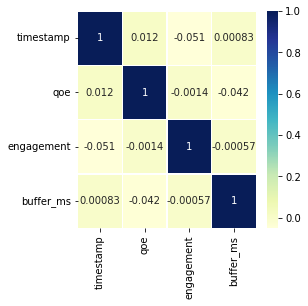

In [ ]:
cor = df[['timestamp','qoe','engagement','buffer_ms']].corr()
fig, ax = plt.subplots(figsize=(4,4)) 
sns.heatmap(cor, cmap="YlGnBu", annot = True, linewidths=.3, ax=ax)

The categorical feature 'viewer_type' can produce statistically significant correlation values as well. To calculate these values I use point biserial correlation:

In [ ]:
df.viewer_type.replace({"WFO": 0, "WFH": 1},inplace=True)

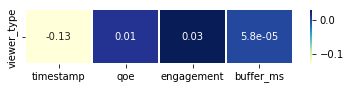

In [ ]:
res = np.zeros((1,4))
res[0,0] = stats.pointbiserialr(df['viewer_type'].to_numpy(),df['timestamp'].to_numpy()).correlation
res[0,1] = stats.pointbiserialr(df['viewer_type'].to_numpy(),df['qoe'].to_numpy()).correlation
res[0,2] = stats.pointbiserialr(df['viewer_type'].to_numpy(),df['engagement'].to_numpy()).correlation
res[0,3] = stats.pointbiserialr(df['viewer_type'].to_numpy(),df['buffer_ms'].to_numpy()).correlation
 
fig, ax = plt.subplots(figsize=(6,1)) 

sns.heatmap(res, cmap="YlGnBu", annot = True, linewidths=.3, xticklabels=['timestamp','qoe','engagement','buffer_ms'], yticklabels = ['viewer_type'],ax=ax)

# Correlations between viewer engagement and different factors

## Number of viewers during the event

In [ ]:
viewers_num_df = pd.DataFrame(columns = ['viewers_num','engagement'])
for EventId in tqdm(range(734)):
  event_df = df[df['event_id'] == EventId]
  if event_df.shape[0] == 0:
    continue
  event_df = event_df[['viewer_id','engagement','date_time']]
  event_df = event_df.assign(date_time=event_df.date_time.dt.round('0.5min'))
  event_grouped_df = event_df.groupby(['viewer_id','date_time']).mean(['engagement']).reset_index()
  temp1_df = event_grouped_df.groupby(['date_time']).size().to_frame(name = 'viewers_num').reset_index()
  temp2_df = event_grouped_df.groupby(['date_time']).mean(['engagement']).reset_index()
  temp2_df = temp2_df.drop(['viewer_id'], axis=1)
  viewers_num_event_df = pd.merge(temp1_df, temp2_df, on='date_time')
  viewers_num_event_df = viewers_num_event_df.drop(['date_time'], axis=1)
  viewers_num_df = viewers_num_df.append(viewers_num_event_df)
viewers_num_df['viewers_num'] = viewers_num_df['viewers_num'].astype(str).astype(int)

100%|██████████| 734/734 [01:01<00:00, 11.98it/s]


In [ ]:
corr1 = viewers_num_df['viewers_num'].corr(viewers_num_df['engagement'])
print("Engagement - number of viewers correlation:",corr1)

Engagement - number of viewers correlation: -0.012480737922117159


Excluding the cases in which there are less than 100 viewers in the event,
the calculated correlation value is more informative:

In [ ]:
viewers_num_df = viewers_num_df[viewers_num_df.viewers_num >= 100]
corr2 = viewers_num_df['viewers_num'].corr(viewers_num_df['engagement'])
print("Engagement - number of viewers correlation (>= 100 viewers):",corr2)

Engagement - number of viewers correlation (>= 100 viewers): -0.10647219798192936


## Day of the event

In [ ]:
week_day_df = df[['event_id','engagement','date_time']]
week_day_df = week_day_df.assign(day_of_week = week_day_df.date_time.dt.day_of_week)
week_day_df['day_of_week'] = week_day_df['day_of_week'].map({0: "Monday",1: "Tuesday",2: "Wednesday",3: "Thursday", 4: "Friday", 5: "Saturday",6: "Sunday"})
week_day_df = pd.get_dummies(data=week_day_df,columns=['day_of_week'])

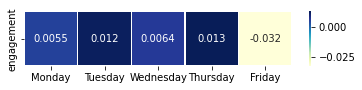

In [ ]:
res = np.zeros((1,5))
res[0,0] = stats.pointbiserialr(week_day_df['day_of_week_Monday'].to_numpy(),week_day_df['engagement'].to_numpy()).correlation
res[0,1] = stats.pointbiserialr(week_day_df['day_of_week_Tuesday'].to_numpy(),week_day_df['engagement'].to_numpy()).correlation
res[0,2] = stats.pointbiserialr(week_day_df['day_of_week_Wednesday'].to_numpy(),week_day_df['engagement'].to_numpy()).correlation
res[0,3] = stats.pointbiserialr(week_day_df['day_of_week_Thursday'].to_numpy(),week_day_df['engagement'].to_numpy()).correlation
res[0,4] = stats.pointbiserialr(week_day_df['day_of_week_Friday'].to_numpy(),week_day_df['engagement'].to_numpy()).correlation
 
fig, ax = plt.subplots(figsize=(6,1)) 

sns.heatmap(res, cmap="YlGnBu", annot = True, linewidths=.3, xticklabels=['Monday','Tuesday','Wednesday','Thursday','Friday'], yticklabels = ['engagement'],ax=ax)

## Duration of the event

In [ ]:
event_duration_df = pd.DataFrame(columns = ['mean_engagement','duration_mins'])

for EventId in tqdm(range(734)):
  event_df = df[df['event_id'] == EventId]
  if event_df.shape[0] == 0:
    continue
  event_mean_engagement = event_df.engagement.mean()
  event_start = event_df.date_time.min()
  event_end = event_df.date_time.max()
  event_duration_mins = (event_end-event_start).total_seconds()/60
  cur_event_df = pd.DataFrame({'mean_engagement': [event_mean_engagement],'duration_mins': [event_duration_mins]})
  event_duration_df = event_duration_df.append(cur_event_df)

100%|██████████| 734/734 [00:37<00:00, 19.41it/s]


In [ ]:
corr3 = event_duration_df['duration_mins'].corr(event_duration_df['mean_engagement'])
print("Engagement - event duration correlation:",event_duration_df['duration_mins'].corr(event_duration_df['mean_engagement']))

Engagement - event duration correlation: 0.2664244622338811


## Countries

In [ ]:
country_engagement_list = []

for CountryId in range(124):
  country_engagement_list.append([CountryId,df[df['country_id'] == CountryId]['engagement'].mean()])

country_engagement_list.sort(key=lambda x: x[1],reverse = True)
  

In [ ]:
print("="*10,"Countries with higher engagement","="*10)
for i in range(0,5):
  print("country_id: {:d}, engagement: {:f}".format(country_engagement_list[i][0],country_engagement_list[i][1]))
print("="*10,"Countries with lower engagement","="*10)
for i in range(119,124):
  print("country_id: {:d}, engagement: {:f}".format(country_engagement_list[i][0],country_engagement_list[i][1]))

========== Countries with higher engagement ==========
country_id: 122, engagement: 0.884480
country_id: 112, engagement: 0.852580
country_id: 88, engagement: 0.839920
country_id: 114, engagement: 0.795306
country_id: 77, engagement: 0.775488
========== Countries with lower engagement ==========
country_id: 111, engagement: 0.000000
country_id: 118, engagement: 0.000000
country_id: 119, engagement: 0.000000
country_id: 120, engagement: 0.000000
country_id: 123, engagement: 0.000000


## Viewers’ retention (how much time each viewer participated in the event)

In [ ]:
temp_df = df[['viewer_id','event_id','date_time','engagement']]
temp_df = temp_df.assign(date_time=temp_df.date_time.dt.round('0.5min'))
temp_df = temp_df.groupby(['viewer_id','date_time']).mean('engagement').reset_index()

df_grouped = temp_df.groupby(['viewer_id','event_id'])
retention_df = df_grouped['date_time'].size().reset_index()

retention_df.columns = retention_df.columns.str.replace('date_time', 'participation_duration_mins')
retention_df['participation_duration_mins'] = retention_df['participation_duration_mins']/2

temp_df = df_grouped['engagement'].mean().reset_index()
retention_df = pd.merge(retention_df,temp_df,on = ['viewer_id','event_id'])

In [ ]:
corr4 = retention_df['engagement'].corr(retention_df['participation_duration_mins'])
print("Engagement - viewer retention correlation:",corr4)

Engagement - viewer retention correlation: 0.12289224450333856


## Heatmap - summary of correlations between continuous features

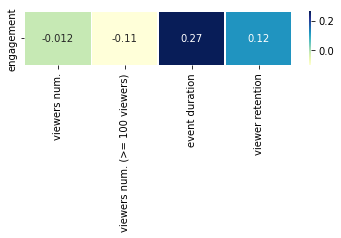

In [ ]:
res = np.zeros((1,4))
res[0,0] = corr1
res[0,1] = corr2
res[0,2] = corr3
res[0,3] = corr4
 
fig, ax = plt.subplots(figsize=(6,1)) 

sns.heatmap(res, cmap="YlGnBu", annot = True, linewidths=.3, xticklabels=['viewers num.','viewers num. (>= 100 viewers)','event duration','viewer retention'], yticklabels = ['engagement'],ax=ax)

# Modelling

## ARIMA - Calculation of the target values

I am going to detect the events which include network anomalies and define the target output values for the Neural Network I am going to train. For this purpose I am going to build a predictive model using the algorithm ARIMA.

Calculating the targets for the events...:  82%|████████▏ | 600/734 [1:08:52<13:31,  6.05s/it]

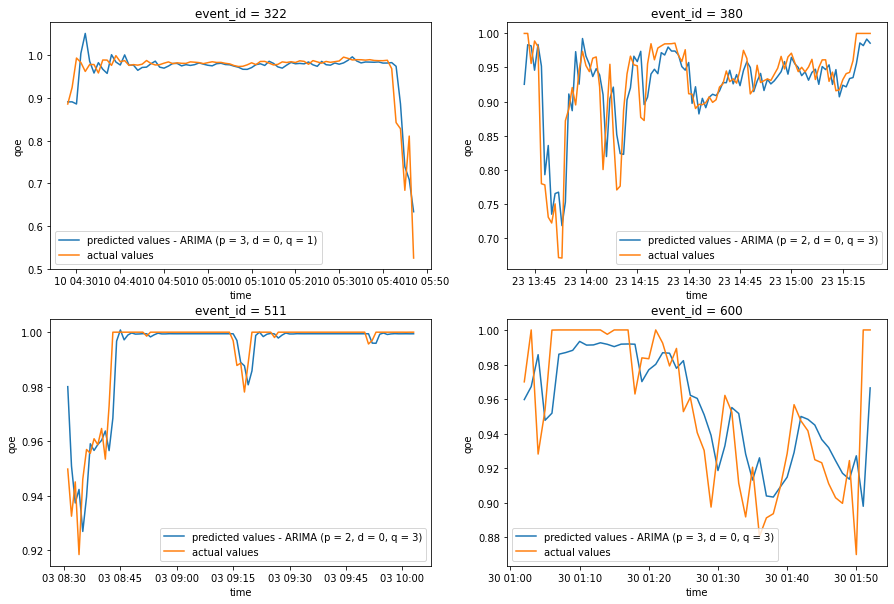

Calculating the targets for the events...: 100%|██████████| 734/734 [1:20:54<00:00,  6.61s/it]


In [8]:
import warnings
warnings.filterwarnings("ignore")

event_list = []
sample_events = sample(range(0, 733), 4)
index = -1
fig, axes = plt.subplots(2, 2,figsize=(15,10))

for EventId in tqdm(range(734), desc = "Calculating the targets for the events..."):
  event_df = df[df['event_id'] == EventId]
  if event_df.shape[0] == 0:
    continue
  temp_df = event_df[['date_time','qoe']]
  temp_df = temp_df.assign(date_time=temp_df.date_time.dt.round('min'))
  temp = temp_df.groupby('date_time').mean().reset_index()
  if temp.shape[0] <= 2:
    continue

  interpolate = True
  while interpolate:
    interpolate = False
    for i in range(temp.shape[0]-1):
      if temp['date_time'].iloc[i+1]-temp['date_time'].iloc[i] != pd.Timedelta(1, "min"):
        interpolate = True
        time_diff = temp['date_time'].iloc[i+1]-temp['date_time'].iloc[i]
        time_diff = int(time_diff.seconds/60)
        qoe_start = temp['qoe'].iloc[i]
        qoe_end = temp['qoe'].iloc[i+1]
        temp_list = temp.values.tolist()

        for j in range(1,time_diff):
          temp_list.insert(i+j,[temp['date_time'].iloc[i] + pd.Timedelta(j, "min"),qoe_start + (qoe_end - qoe_start)*j/time_diff])
        temp = pd.DataFrame(temp_list, columns =['date_time','qoe'])

  min_mse = 1
  p_optimal = -1
  d_optimal = -1
  q_optimal = -1

  for p in range(4):
    for d in range(2):
      for q in range(4):
        try:
          model = ARIMA(endog=temp['qoe'].values,dates = temp['date_time'].values,freq = 'T',order = (p,d,q))
          res = model.fit()
          mse = mean_squared_error(res.predict(),temp['qoe'].squeeze())
          if mse < min_mse:
            min_mse = mse
            p_optimal = p
            d_optimal = d
            q_optimal = q
        except:
          continue
        
  model = ARIMA(endog=temp['qoe'].values,dates = temp['date_time'].values,freq = 'T',order = (p_optimal,d_optimal,q_optimal))
  res = model.fit()

  if EventId in sample_events:
    index += 1
    axes[int(index/2),index%2].plot(temp['date_time'].squeeze(),res.predict())
    axes[int(index/2),index%2].plot(temp['date_time'].squeeze(),temp['qoe'].squeeze())
    axes[int(index/2),index%2].legend(['predicted values - ARIMA (p = {:d}, d = {:d}, q = {:d})'.format(p_optimal,d_optimal,q_optimal),'actual values'])
    axes[int(index/2),index%2].title.set_text('event_id = {:d}'.format(EventId))
    axes[int(index/2),index%2].set_xlabel('time')
    axes[int(index/2),index%2].set_ylabel('qoe')
    if index == 3:
      plt.show()

  if res.resid.shape[0] < 5:
    continue
  res.resid = res.resid[2:res.resid.shape[0]-3]
  max_residual = max(abs(res.resid))
  
  if max_residual > 0.1:
    event_list.append(EventId)

In [ ]:
print("Events with anomalies: {:d} ({:.2f}% of the total events)".format(len(event_list),len(event_list)/7.31))

Events with anomalies: 109 (14.91% of the total events)


In [ ]:
targets = []

for i in tqdm(range(734)):
  if  df[df['event_id'] == i].shape[0] == 0:
    continue
  if i in event_list:
    targets.append(1)
  else:
    targets.append(0)

targets_df = pd.DataFrame(targets, columns =['target'])

100%|██████████| 734/734 [00:31<00:00, 23.22it/s]


## Creating the data set

### viewer_id encoding

In [ ]:
viewer_event_array = np.zeros((734,108974))

for i in tqdm(range(df.shape[0])):
  cur_row = df.iloc[i]
  viewer_event_array[int(cur_row['event_id']),int(cur_row['viewer_id'])] += 1

100%|██████████| 20615370/20615370 [1:00:29<00:00, 5679.19it/s]


In [ ]:
#delete rows and columns with zeros
viewer_event_array = viewer_event_array[~np.all(viewer_event_array == 0, axis=1)]
idx = np.argwhere(np.all(viewer_event_array[..., :] == 0, axis=0))
viewer_event_array = np.delete(viewer_event_array, idx, axis=1)

In [ ]:
temp_df = pd.DataFrame(viewer_event_array)
ix = temp_df.sum().sort_values(ascending=False, inplace=False)
temp_df = temp_df[ix.index[:10000]]

In [ ]:
scaler = MinMaxScaler()
viewer_event_scaled = scaler.fit_transform(temp_df.to_numpy())

In [ ]:
model_df = pd.DataFrame(viewer_event_scaled)
del viewer_event_array
del viewer_event_scaled

### country_id encoding

In [ ]:
country_event_array = np.zeros((734,124))

for i in tqdm(range(df.shape[0])):
  cur_row = df.iloc[i]
  country_event_array[int(cur_row['event_id']),int(cur_row['country_id'])] += 1

100%|██████████| 20615370/20615370 [48:02<00:00, 7152.75it/s]


In [ ]:
country_event_array = country_event_array[~np.all(country_event_array == 0, axis=1)]
idx = np.argwhere(np.all(country_event_array[..., :] == 0, axis=0))
country_event_array = np.delete(country_event_array, idx, axis=1)

In [ ]:
scaler = MinMaxScaler()
country_event_scaled = scaler.fit_transform(country_event_array)

In [ ]:
country_df = pd.DataFrame(country_event_scaled)
del country_event_array
del country_event_scaled
model_df = pd.concat([model_df,country_df],axis = 1,ignore_index = True)

### city_id encoding




In [ ]:
city_event_array = np.zeros((734,8243))

for i in tqdm(range(df.shape[0])):
  cur_row = df.iloc[i]
  city_event_array[int(cur_row['event_id']),int(cur_row['city_id'])] += 1

100%|██████████| 20615370/20615370 [1:02:25<00:00, 5504.12it/s]


In [ ]:
city_event_array = city_event_array[~np.all(city_event_array == 0, axis=1)]
idx = np.argwhere(np.all(city_event_array[..., :] == 0, axis=0))
city_event_array = np.delete(city_event_array, idx, axis=1)

In [ ]:
temp_df = pd.DataFrame(city_event_array)
ix = temp_df.sum().sort_values(ascending=False, inplace=False)
temp_df = temp_df[ix.index[:4000]]

In [ ]:
scaler = MinMaxScaler()
city_event_scaled = scaler.fit_transform(temp_df.to_numpy())

In [ ]:
city_df = pd.DataFrame(city_event_scaled)
del city_event_array
del city_event_scaled
model_df = pd.concat([model_df,city_df],axis = 1,ignore_index = True)

### engagement inputs

In [ ]:
engagement_mean = []

for i in tqdm(range(734)):
  event_df = df[df['event_id'] == i]
  if event_df.shape[0] == 0:
    continue
  event_df.sort_values(by = ['date_time'])
  engagement_event_list = []
  if event_df.shape[0] <= 100:
    engagement_event_list += 100*[event_df['engagement'].mean()]
  else:
    for item in np.array_split(event_df,100):
      engagement_event_list.append(item['engagement'].mean())
  engagement_mean.append(engagement_event_list)

scaler = MinMaxScaler()
engagement_mean = scaler.fit_transform(np.array(engagement_mean))

engagement_mean_df = pd.DataFrame(engagement_mean)
model_df = pd.concat([model_df,engagement_mean_df],axis = 1,ignore_index = True)

100%|██████████| 734/734 [00:53<00:00, 13.75it/s]


### buffer_ms inputs

In [ ]:
buffer_ms_mean = []

for i in tqdm(range(734)):
  event_df = df[df['event_id'] == i]
  if event_df.shape[0] == 0:
    continue
  event_df.sort_values(by = ['date_time'])
  buffer_ms_event_list = []
  if event_df.shape[0] <= 100:
    buffer_ms_event_list += 100*[event_df['buffer_ms'].mean()]
  else:
    for item in np.array_split(event_df,100):
      buffer_ms_event_list.append(item['buffer_ms'].mean())
  buffer_ms_mean.append(buffer_ms_event_list)

scaler = MinMaxScaler()
buffer_ms_mean = scaler.fit_transform(np.array(buffer_ms_mean))

buffer_ms_mean_df = pd.DataFrame(buffer_ms_mean)
model_df = pd.concat([model_df,buffer_ms_mean_df],axis = 1,ignore_index = True)

100%|██████████| 734/734 [00:49<00:00, 14.71it/s]


### The final input DataFrame for the model

In [ ]:
model_df.shape

(731, 14324)

In [ ]:
model_df.head()

,0,1,2,3,4,5,6,7,8,9,...,14314,14315,14316,14317,14318,14319,14320,14321,14322,14323
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003040,0.011514,0.005551,0.000852,0.005686,0.007470,0.000870,0.009119,0.001892,0.010036
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000845,0.002519,0.049238,0.000193,0.003271,0.002559,0.000693,0.143356,0.001446,0.006228
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005830,0.020421,0.009050,0.002165,0.007220,0.014780,0.001628,0.020535,0.006673,0.027543
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003315,0.013023,0.006937,0.001404,0.019131,0.007197,0.001646,0.011593,0.009155,0.033642
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003615,0.005536,0.006243,0.000502,0.005754,0.007804,0.000731,0.005966,0.002856,0.012083


## Neural Network implementation

In [ ]:
! pip install pytorch-lightning
! pip install pytorch-lightning-bolts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import torch
from torch import nn
import torchmetrics
import torch.nn.functional as F
from torchvision import transforms
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from sklearn.metrics import confusion_matrix

In [ ]:
targets = torch.tensor(targets_df.values).float().reshape(len(targets),1)
features = torch.tensor(model_df.values).float()
dataset = data_utils.TensorDataset(features, targets)

anomaly_list = []
not_anomaly_list = []

for i in range(731):
  if dataset[i][1].item() == 0:
    not_anomaly_list.append(i)
  else:
    anomaly_list.append(i)

In [ ]:
train_set_list = []
test_set_list = []
train_set_list = anomaly_list[0:80] + not_anomaly_list[0:240]
test_set_list = anomaly_list[80:109] + not_anomaly_list[240:269]

In [ ]:
train_set = torch.utils.data.Subset(dataset, train_set_list)
test_set = torch.utils.data.Subset(dataset, test_set_list)

In [ ]:
train_loader = DataLoader(train_set, batch_size=1, shuffle = True, num_workers=2)
test_loader = DataLoader(test_set)

In [ ]:
class LitModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Conv1d(in_channels = 1, out_channels=32, kernel_size=10,stride = 2,padding = 1),
                                   nn.MaxPool1d(5),
                                   nn.Conv1d(in_channels = 32, out_channels=16, kernel_size=10,stride = 2,padding = 1),
                                   nn.MaxPool1d(5),
                                   nn.Conv1d(in_channels = 16, out_channels=1, kernel_size=8,stride = 2,padding = 1),
                                   nn.Linear(69,1),nn.Sigmoid())
                                  
        self.loss_function = F.mse_loss
        self.accuracy = torchmetrics.Accuracy()

    def training_step(self, batch, batch_idx):  
        x, y = batch
        x = x.view(x.size(0), -1)
        y_pred = self.model(x)
        loss = self.loss_function(y_pred, y)
        self.log('train_loss', loss)
        return {"loss": loss}

    def training_epoch_end(self, training_step_outputs):
        loss_lst = [d['loss'].item() for d in training_step_outputs]
        mse = sum(loss_lst)/len(loss_lst)
        print("="*45)
        print("Epoch:",self.current_epoch,"- MSE =",mse)
        print("="*45)
        return   

    def test_step(self, batch, batch_idx):  
        x, y = batch
        x = x.view(x.size(0), -1)
        y_pred = torch.round(self.model(x))
        y_pred = y_pred.type(torch.int64)
        y = y.type(torch.int64)
        self.accuracy(y_pred,y)
        return {"y_pred":y_pred,"y":y}

    def test_epoch_end(self, test_step_outputs):  
        self.log('test_acc_epoch', self.accuracy)
        y_preds = [d['y_pred'].item() for d in test_step_outputs]
        y_actuals = [d['y'].item() for d in test_step_outputs]
        acc_array = confusion_matrix(y_preds,y_actuals)
        acc_df = pd.DataFrame(acc_array, index = ['predicted not anomaly','predicted anomaly'], columns = ['actual not anomaly','actual anomaly'])
        plt.figure(figsize = (4,4))
        sns.heatmap(acc_df, annot=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [ ]:
model = LitModel()
trainer = pl.Trainer(gpus=1, max_epochs=40,log_every_n_steps=1)
trainer.fit(model, train_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | model    | Sequential | 5.7 K 
1 | accuracy | Accuracy   | 0     
----------------------------------------
5.7 K     Trainable params
0         Non-trainable params
5.7 K     Total params
0.023     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch: 0 - MSE = 0.19469655298962607
Epoch: 1 - MSE = 0.17996328159908964
Epoch: 2 - MSE = 0.16869324360776022
Epoch: 3 - MSE = 0.16177261629980244
Epoch: 4 - MSE = 0.157193679569521
Epoch: 5 - MSE = 0.14945691260159108
Epoch: 6 - MSE = 0.14512939119679777
Epoch: 7 - MSE = 0.13749653306799553
Epoch: 8 - MSE = 0.13301708123677564
Epoch: 9 - MSE = 0.1234534655095086
Epoch: 10 - MSE = 0.1118589464363682
Epoch: 11 - MSE = 0.10581753241739364
Epoch: 12 - MSE = 0.09570148206139639
Epoch: 13 - MSE = 0.08592165790155767
Epoch: 14 - MSE = 0.07002389959514367
Epoch: 15 - MSE = 0.06838684928409826
Epoch: 16 - MSE = 0.06302410799049199
Epoch: 17 - MSE = 0.05560866769205649
Epoch: 18 - MSE = 0.050147355258002735
Epoch: 19 - MSE = 0.04285248282458231
Epoch: 20 - MSE = 0.03823434366028711
Epoch: 21 - MSE = 0.03630493008684736
Epoch: 22 - MSE = 0.03372776567307524
Epoch: 23 - MSE = 0.033674845570320903
Epoch: 24 - MSE = 0.030070164139292817
Epoch: 25 - MSE = 0.024822515270381214
Epoch: 26 - MSE = 0.02

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch          0.931034505367279
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc_epoch': 0.931034505367279}]

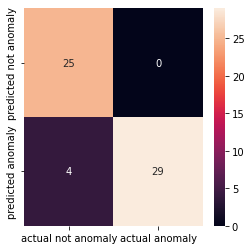

In [ ]:
trainer.test(model, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.9937499761581421
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc_epoch': 0.9937499761581421}]

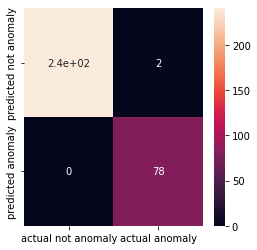

In [ ]:
trainer.test(model, dataloaders=DataLoader(train_set))